## Simple GPT2 Impelmentation - Training on Game of Thrones 

This notebook implements a simple GPT2 model using the papers: 
    
1) Improving Language Understanding by Generative Pre-Training (OpenAI)

2) Attention Is All You Need (Google Brain)

3) Using the Output Embedding to Improve Language Models (weight tying)

4) https://people.idsia.ch/~juergen/fast-weight-programmer-1991-transformer.html - the history of attention

(This notebook is heavily annotated which detrements readability but hopefully helps explain how the multi-head attention is implemented using PyTorch.)


In [176]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from typing import Tuple

torch.manual_seed(1)

In [177]:
class Text_Handler:
    
    def __init__(self, file_name, context_length, test_size=0.2):
        self.context_length = context_length 
        assert self.context_length != 0
        self.raw_text = self.load_text(file_name)
        self.vocab_size, self.stoi, self.itos = self.pre_process_text()
        self.encode = lambda s: [self.stoi[c] for c in s]
        self.decode = lambda l: "".join([self.itos[i] for i in l])
        
        # Load, split without shuffle and make context length exmaples.
        self.text = torch.tensor(self.encode(self.raw_text), dtype=torch.long)
        self.train_text, self.test_text = train_test_split(self.text, test_size=0.2, shuffle=False)
        self.X_train, self.Y_train = self.make_examples(self.train_text)
        self.X_test, self.Y_test = self.make_examples(self.test_text)
        
        self.train_dataset = TensorDataset(self.X_train, self.Y_train)
        self.test_dataset = TensorDataset(self.X_test, self.Y_test)
        print(f"Number of training and testing examples: {len(self.train_dataset)}, {len(self.test_dataset)}")
                
    def load_text(self, file_name): 
        try:
            with open(file_name, "r", encoding="utf8") as f:
                return f.read()
        except FileNotFoundError:
            raise FileNotFoundError(f"File {file_name} does not exist within the working directory.")
            
    def pre_process_text(self):
        chars = sorted(list(set(self.raw_text)))
        vocab_size = len(chars)
        stoi = {char: i for i, char in enumerate(chars)}
        itos = {i: char for char, i in stoi.items()}
        return vocab_size, stoi, itos
    
    def make_examples(self, text: torch.Tensor, verbose=False) -> Tuple[torch.Tensor, torch.Tensor]:
        n_examples = text.shape[0] - self.context_length
        X = torch.empty(n_examples, self.context_length, dtype=torch.long)
        Y = torch.empty(n_examples, self.context_length, dtype=torch.long)
        
#         ix = torch.randint(len(data) - block_size, (batch_size,))
#         x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
#         y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])

        for i in range(n_examples):
            X[i] = text[i:i+self.context_length]
#             Y[i] = text[i+self.context_length]
            Y[i] = text[i+1:i+1+block_size]
            if verbose: print(f"Example {i+1:2d}: {X[i].tolist()} --> {Y[i].item()}")

        return X, Y


In [178]:
# GPT2 implementation

class Causal_Self_Attention(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        # Make sure we can project the embeddings across the attention heads:
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd # = model dimension
        
        # Layer to generate keys, queries, values in one pass:
        self.attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.attn_dropout = nn.Dropout(config.dropout)
        
        # Make sure the causal mask is saved to the state dict and is moved with the model to the GPU. 
        self.register_buffer("causal_mask", torch.tril(torch.ones(config.context_length, config.context_length))
                                    .view(1, 1, config.context_length, config.context_length))
        
        # Final lienar transfromation after multi-head attention
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.proj_dropout = nn.Dropout(config.dropout)
    
    def forward(self, x, targets=None):

        # batch size = number of graphs processed at once 
        # context legnth = number of nodes in the graph
        # channels = embedding dimensionality of each node = attention_component_size
        n_graphs, n_nodes, attention_component_size = x.size() 
        
        # Calculate the keys, queries and values of all the nodes in each graph using the nodes' embeddings.
        # Each component q,k,v remains the same size as the embedding dimensionality: n_embd = size_components q,k,v.
        queries, keys, values  = self.attn(x).split(self.n_embd, dim=2) # Each have: (n_graphs, n_nodes, size_components=n_embd)
        
        # Split each node and its attention components across the heads (= project the The "key", "query", and "value"s across the heads):
    
        # (n_graphs, n_nodes, size_components) -> (n_graphs, n_nodes, n_heads, size_components/n_heads = split_information)^T(1,2) -> (n_graphs, n_heads, n_nodes, split_information)
        queries = queries.view(n_graphs, n_nodes, self.n_head, attention_component_size // self.n_head).transpose(1, 2)
        keys = keys.view(n_graphs, n_nodes, self.n_head, attention_component_size // self.n_head).transpose(1, 2)
        values = values.view(n_graphs, n_nodes, self.n_head, attention_component_size // self.n_head).transpose(1, 2)
        
        
        # Implement scaled dot product attention for graph in each attention head. 
        # i.e. how all the nodes talk to eachother when their info is split across the heads: (attention_component_size // self.n_head). 
        # This "split_information" is the dimension which is dot producted over in each graph, leaving: 
        # --> n_heads * n_nodes * n_nodes ! i.e. in each head you have n_nodes talking to n_nodes. 
        
    
        # For each graph in each head: (n_nodes, split_information) * (n_nodes, split_information)^T
        # (n_graphs, n_heads, n_nodes, split_information) * (n_graphs, n_heads, split_information, n_nodes) -> (n_graphs, n_heads, n_nodes, n_nodes)
        # Normalise by the size of the split_information.
        att = (queries @ keys.transpose(-2, -1)) * (1.0 / math.sqrt(keys.size(-1)))
        
        
        # Apply the causal mask to each graph.  
        # The indexing here allows us to handle sequences shorter than the full context length. 
        att = att.masked_fill(self.causal_mask[:,:,:n_nodes,:n_nodes] == 0, float('-inf'))
        
        # Softmax across how each node talks to the nodes causally connected to it.
        # For each node this leaves a "fraction of my attention I will pay to each other nodes' value vector" for each node in the graph.
        
        # "The attention weights (attention fractions) in Transformers can be viewed as context-dependent weight vectors" - Jürgen Schmidhuber
        # see: https://people.idsia.ch/~juergen/fast-weight-programmer-1991-transformer.html
        
        attention_fractions = self.attn_dropout(F.softmax(att, dim=-1))
        
        attention_weighted_value_vectors = attention_fractions @ values 
        
        # Recombine all the heads' attention_weighted_value_vectors.
        # Ensure this is in contigious memory.
        attention_weighted_value_vectors = attention_weighted_value_vectors.transpose(1, 2).contiguous().view(n_graphs, n_nodes, attention_component_size)
        
        # Apply the final linear transforamtion to leave the output with the same dimensions as the input for a residual connection.
        out = self.proj_dropout(self.proj(attention_weighted_value_vectors))

        return out

In [179]:
class Multi_Layer_Perceptron(nn.Module):

    def __init__(self, config):
        super().__init__()
        # 4X step up as in the paper, and GeLu to stop dead neurons.
        self.fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.fc(x)
        x = self.nonlin(x)
        x = self.proj(x)
        return x

In [180]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        # Normalise before and after the self attention as in the paper. 
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = Causal_Self_Attention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = Multi_Layer_Perceptron(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [187]:
class GPT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.context_length is not None
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            token_embd = nn.Embedding(config.vocab_size, config.n_embd),
            positional_embd = nn.Embedding(config.context_length, config.n_embd),
            attention_stack = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            final_ln = nn.LayerNorm(config.n_embd)))
        
        self.output_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        
        # The output head and the token embeddings have the same dimension.
        # So both learn vector representaions of tokens.
        # Paper: "We study the topmost weight matrix of neural network language models. 
        # We show that this matrix constitutes a validword embedding."
        # PyTorch accumululates (adds) the gradients of both together in a backwards pass.
        self.transformer.token_embd.weight = self.output_head.weight
        
        self.apply(self._init_weights)
        
        # Apply special scaled init to the residual projections, per GPT-2 paper
        for name, param in self.named_parameters():
            if name.endswith('proj.weight'):
                torch.nn.init.normal_(param, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))
        
        # Print the number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))
    
    def _init_weights(self, module):
        # "Since layernorm [2] is used extensively throughout the model, a simple weight initialization of 
        # N(0, 0.02) was sufficient."
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
                
    def forward(self, seq, targets=None):
        device = seq.device
        n_graphs, n_nodes = seq.size()
        assert n_nodes <= self.config.context_length, f"Cannot forward sequence {seq} of length {n_nodes} as it exceeds the maximum context legnth {self.config.context_length}."
        positions = torch.arange(0, n_nodes, dtype=torch.long, device=device).unsqueeze(dim=0)
        
        token_embd = self.transformer.token_embd(seq)
        positional_embd = self.transformer.positional_embd(positions)
        
        # x = embedded graph
        x = token_embd + positional_embd
        
        # residual attention stack 
        for block in self.transformer.attention_stack:
            x = block(x)
        x = self.transformer.final_ln(x)
        
        if targets is not None:
            logits = self.output_head(x)
            # Aggregate/concat the tesnors over all the (context_length - 1) sequences per example with view(-1).
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            
        else:
            logits = self.output_head(x[:, -1, :]) # only logits of the prediction over the vocab space.
            loss = None
        return logits, loss
        
        

In [182]:
@dataclass
class GPTConfig:
    # Default GPT-2 hyperparameters from the paper
    context_length: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.1
    bias: bool = False

In [197]:
class Trainer:
    def __init__(self, text_handler, save_path, config=None, load_path=None):
        self.load_checkpoint(load_path)
        self.text_handler = text_handler
        self.config = config
        self.save_path = save_path
        
    def load_checkpoint(self, path):
        if path is not None:
            # Load the saved model, optimiser state, and losses from checkpoint
            checkpoint = torch.load(path)
            self.config = checkpoint['config']

            self.model = GPT(config)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-1)
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            self.train_losses = checkpoint['train_losses']
            self.plot_loss(smoothing_window=1000)
            
        else:
            # Start from scratch
            assert config is not None, "You must provide a configuration for the GPT if training from scratch."
            self.model = GPT(config)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-1)
            self.train_losses = []
    
        
    def train(self, n_epochs, bs, training_data_frac=1):
        self.model.train()
        train_loader = DataLoader(self.text_handler.train_dataset, batch_size=bs, shuffle=True)
        n_batches = int(len(train_loader) * training_data_frac)
        print(f"Training on {n_batches}/{len(train_loader)} batches per epoch.")
        
        for epoch in range(n_epochs):
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    if batch_idx >= n_batches:
                        break 
                    logits, loss = self.model(X_batch, y_batch)
                    self.optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    self.optimizer.step()
                    self.train_losses.append(loss.item())
                    print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.3f}")
        
        self.plot_loss(smoothing_window=1000)            
        self.save_checkpoint()
        
    def generate_text(self, starting_seq, temp, n_steps):
        
        encoded_seq = self.text_handler.encode(starting_seq)
        working_seq = encoded_seq.copy()
        
        self.model.eval()
        for _ in range(n_steps):
            x = torch.tensor(working_seq, dtype=torch.long).unsqueeze(dim=0)
            logits, _ = self.model(x)
            # apply a temperature to chnage the shape of the next token distribution 
            logits = logits / temp
            probs = nn.functional.softmax(logits, dim=-1)
            # sample from the distribution
            next_token = torch.multinomial(probs[0], num_samples=1).item()
            encoded_seq.append(next_token)
            working_seq = working_seq[1:] + [next_token]

        print(self.text_handler.decode(encoded_seq))

    def save_checkpoint(self):
        self.model.eval()            
        torch.save({'model_state_dict': self.model.state_dict(),
                    'config': self.config,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_losses': self.train_losses}, self.save_path)
        
    @staticmethod
    def moving_average(data, window_size):
        series = pd.Series(data)
        moving_avg = series.rolling(window=window_size).mean()
        return moving_avg.tolist()
    
    def plot_loss(self, smoothing_window):
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(self.moving_average(self.train_losses, smoothing_window))
        ax.set_ylabel("Smoothed Training loss")
     
        

# Training 

In [76]:
# Preproccess the raw text
context_length = 24 # or number of nodes in the communication graph 
text_handler = Text_Handler("gameofthrones.txt", context_length)

Number of training and testing examples: 4529833, 1132441


In [184]:
text_handler.vocab_size, text_handler.decode(text_handler.X_train[0].tolist()), \
text_handler.decode(text_handler.Y_train[0].tolist())

(86, '“We should start back,” ', 'We should start back,” G')

In [190]:
print(f"Expected Starting loss: {F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1).item():.2f}")


Expected Starting loss: 4.45


number of parameters: 8592


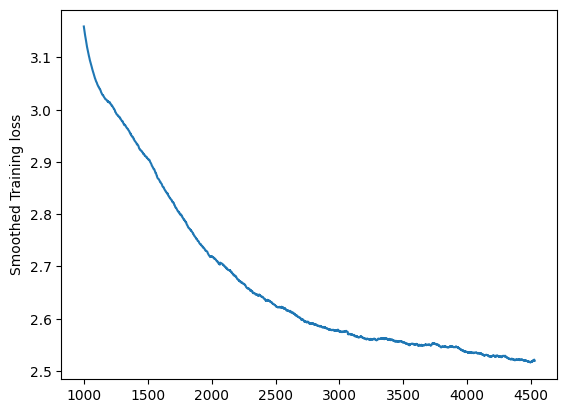

In [216]:
# Train setup
save_path = 'GOT_GPT.pth'
load_path = 'GOT_GPT.pth'
# load_path = None

config = GPTConfig(
    context_length = context_length,
    vocab_size = text_handler.vocab_size,
    n_layer = 4,
    n_head = 2,
    n_embd = 12,
    dropout = 0.1,
    bias = False)

model_trainer = Trainer(text_handler, save_path, config, load_path)


In [231]:
# Train params
bs = 16
n_epochs = 1
training_data_frac = 0.05
print(f"Examples in a batch {bs*context_length}")

Examples in a batch 384


Training on 14155/283115 batches per epoch.
Epoch: 0, Batch: 0, Loss: 2.158
Epoch: 0, Batch: 1, Loss: 2.139
Epoch: 0, Batch: 2, Loss: 2.087
Epoch: 0, Batch: 3, Loss: 2.238
Epoch: 0, Batch: 4, Loss: 2.194
Epoch: 0, Batch: 5, Loss: 2.172
Epoch: 0, Batch: 6, Loss: 2.273
Epoch: 0, Batch: 7, Loss: 2.168
Epoch: 0, Batch: 8, Loss: 2.226
Epoch: 0, Batch: 9, Loss: 2.198
Epoch: 0, Batch: 10, Loss: 2.173
Epoch: 0, Batch: 11, Loss: 2.204
Epoch: 0, Batch: 12, Loss: 2.252
Epoch: 0, Batch: 13, Loss: 2.046
Epoch: 0, Batch: 14, Loss: 2.152
Epoch: 0, Batch: 15, Loss: 1.985
Epoch: 0, Batch: 16, Loss: 2.378
Epoch: 0, Batch: 17, Loss: 2.023
Epoch: 0, Batch: 18, Loss: 2.162
Epoch: 0, Batch: 19, Loss: 2.208
Epoch: 0, Batch: 20, Loss: 2.136
Epoch: 0, Batch: 21, Loss: 2.204
Epoch: 0, Batch: 22, Loss: 2.189
Epoch: 0, Batch: 23, Loss: 2.100
Epoch: 0, Batch: 24, Loss: 2.119
Epoch: 0, Batch: 25, Loss: 2.143
Epoch: 0, Batch: 26, Loss: 2.167
Epoch: 0, Batch: 27, Loss: 2.214
Epoch: 0, Batch: 28, Loss: 2.226
Epoch: 0,

Epoch: 0, Batch: 251, Loss: 2.072
Epoch: 0, Batch: 252, Loss: 2.152
Epoch: 0, Batch: 253, Loss: 2.146
Epoch: 0, Batch: 254, Loss: 2.129
Epoch: 0, Batch: 255, Loss: 2.054
Epoch: 0, Batch: 256, Loss: 2.028
Epoch: 0, Batch: 257, Loss: 2.292
Epoch: 0, Batch: 258, Loss: 2.295
Epoch: 0, Batch: 259, Loss: 2.213
Epoch: 0, Batch: 260, Loss: 2.235
Epoch: 0, Batch: 261, Loss: 2.183
Epoch: 0, Batch: 262, Loss: 2.124
Epoch: 0, Batch: 263, Loss: 2.174
Epoch: 0, Batch: 264, Loss: 2.045
Epoch: 0, Batch: 265, Loss: 2.126
Epoch: 0, Batch: 266, Loss: 2.159
Epoch: 0, Batch: 267, Loss: 2.170
Epoch: 0, Batch: 268, Loss: 2.134
Epoch: 0, Batch: 269, Loss: 2.079
Epoch: 0, Batch: 270, Loss: 2.172
Epoch: 0, Batch: 271, Loss: 2.315
Epoch: 0, Batch: 272, Loss: 2.140
Epoch: 0, Batch: 273, Loss: 2.201
Epoch: 0, Batch: 274, Loss: 2.048
Epoch: 0, Batch: 275, Loss: 2.100
Epoch: 0, Batch: 276, Loss: 2.154
Epoch: 0, Batch: 277, Loss: 2.269
Epoch: 0, Batch: 278, Loss: 2.136
Epoch: 0, Batch: 279, Loss: 2.148
Epoch: 0, Batc

Epoch: 0, Batch: 492, Loss: 2.170
Epoch: 0, Batch: 493, Loss: 2.062
Epoch: 0, Batch: 494, Loss: 2.131
Epoch: 0, Batch: 495, Loss: 2.116
Epoch: 0, Batch: 496, Loss: 2.249
Epoch: 0, Batch: 497, Loss: 2.349
Epoch: 0, Batch: 498, Loss: 2.038
Epoch: 0, Batch: 499, Loss: 2.341
Epoch: 0, Batch: 500, Loss: 2.226
Epoch: 0, Batch: 501, Loss: 2.137
Epoch: 0, Batch: 502, Loss: 2.081
Epoch: 0, Batch: 503, Loss: 2.140
Epoch: 0, Batch: 504, Loss: 2.253
Epoch: 0, Batch: 505, Loss: 2.094
Epoch: 0, Batch: 506, Loss: 2.138
Epoch: 0, Batch: 507, Loss: 2.064
Epoch: 0, Batch: 508, Loss: 2.133
Epoch: 0, Batch: 509, Loss: 2.141
Epoch: 0, Batch: 510, Loss: 2.259
Epoch: 0, Batch: 511, Loss: 2.124
Epoch: 0, Batch: 512, Loss: 2.105
Epoch: 0, Batch: 513, Loss: 2.160
Epoch: 0, Batch: 514, Loss: 2.078
Epoch: 0, Batch: 515, Loss: 2.186
Epoch: 0, Batch: 516, Loss: 2.300
Epoch: 0, Batch: 517, Loss: 2.249
Epoch: 0, Batch: 518, Loss: 2.153
Epoch: 0, Batch: 519, Loss: 2.121
Epoch: 0, Batch: 520, Loss: 2.081
Epoch: 0, Batc

Epoch: 0, Batch: 739, Loss: 2.154
Epoch: 0, Batch: 740, Loss: 2.213
Epoch: 0, Batch: 741, Loss: 2.139
Epoch: 0, Batch: 742, Loss: 2.136
Epoch: 0, Batch: 743, Loss: 2.146
Epoch: 0, Batch: 744, Loss: 2.218
Epoch: 0, Batch: 745, Loss: 2.076
Epoch: 0, Batch: 746, Loss: 2.149
Epoch: 0, Batch: 747, Loss: 2.197
Epoch: 0, Batch: 748, Loss: 2.191
Epoch: 0, Batch: 749, Loss: 2.303
Epoch: 0, Batch: 750, Loss: 2.221
Epoch: 0, Batch: 751, Loss: 2.171
Epoch: 0, Batch: 752, Loss: 2.180
Epoch: 0, Batch: 753, Loss: 2.181
Epoch: 0, Batch: 754, Loss: 1.960
Epoch: 0, Batch: 755, Loss: 2.186
Epoch: 0, Batch: 756, Loss: 2.154
Epoch: 0, Batch: 757, Loss: 2.179
Epoch: 0, Batch: 758, Loss: 2.086
Epoch: 0, Batch: 759, Loss: 2.310
Epoch: 0, Batch: 760, Loss: 2.043
Epoch: 0, Batch: 761, Loss: 2.129
Epoch: 0, Batch: 762, Loss: 2.109
Epoch: 0, Batch: 763, Loss: 2.032
Epoch: 0, Batch: 764, Loss: 2.218
Epoch: 0, Batch: 765, Loss: 2.178
Epoch: 0, Batch: 766, Loss: 2.148
Epoch: 0, Batch: 767, Loss: 2.368
Epoch: 0, Batc

Epoch: 0, Batch: 980, Loss: 2.271
Epoch: 0, Batch: 981, Loss: 2.238
Epoch: 0, Batch: 982, Loss: 2.157
Epoch: 0, Batch: 983, Loss: 2.229
Epoch: 0, Batch: 984, Loss: 2.180
Epoch: 0, Batch: 985, Loss: 2.127
Epoch: 0, Batch: 986, Loss: 2.111
Epoch: 0, Batch: 987, Loss: 2.202
Epoch: 0, Batch: 988, Loss: 2.210
Epoch: 0, Batch: 989, Loss: 2.164
Epoch: 0, Batch: 990, Loss: 2.201
Epoch: 0, Batch: 991, Loss: 2.325
Epoch: 0, Batch: 992, Loss: 2.185
Epoch: 0, Batch: 993, Loss: 2.104
Epoch: 0, Batch: 994, Loss: 2.092
Epoch: 0, Batch: 995, Loss: 2.279
Epoch: 0, Batch: 996, Loss: 2.072
Epoch: 0, Batch: 997, Loss: 2.135
Epoch: 0, Batch: 998, Loss: 2.139
Epoch: 0, Batch: 999, Loss: 2.198
Epoch: 0, Batch: 1000, Loss: 2.146
Epoch: 0, Batch: 1001, Loss: 2.063
Epoch: 0, Batch: 1002, Loss: 2.131
Epoch: 0, Batch: 1003, Loss: 2.290
Epoch: 0, Batch: 1004, Loss: 2.344
Epoch: 0, Batch: 1005, Loss: 2.136
Epoch: 0, Batch: 1006, Loss: 2.083
Epoch: 0, Batch: 1007, Loss: 2.291
Epoch: 0, Batch: 1008, Loss: 2.224
Epoch

Epoch: 0, Batch: 1219, Loss: 2.151
Epoch: 0, Batch: 1220, Loss: 2.122
Epoch: 0, Batch: 1221, Loss: 2.171
Epoch: 0, Batch: 1222, Loss: 2.117
Epoch: 0, Batch: 1223, Loss: 2.155
Epoch: 0, Batch: 1224, Loss: 2.263
Epoch: 0, Batch: 1225, Loss: 2.057
Epoch: 0, Batch: 1226, Loss: 2.135
Epoch: 0, Batch: 1227, Loss: 2.172
Epoch: 0, Batch: 1228, Loss: 2.096
Epoch: 0, Batch: 1229, Loss: 2.130
Epoch: 0, Batch: 1230, Loss: 2.163
Epoch: 0, Batch: 1231, Loss: 2.203
Epoch: 0, Batch: 1232, Loss: 2.136
Epoch: 0, Batch: 1233, Loss: 2.195
Epoch: 0, Batch: 1234, Loss: 2.212
Epoch: 0, Batch: 1235, Loss: 2.143
Epoch: 0, Batch: 1236, Loss: 2.213
Epoch: 0, Batch: 1237, Loss: 2.287
Epoch: 0, Batch: 1238, Loss: 2.303
Epoch: 0, Batch: 1239, Loss: 2.031
Epoch: 0, Batch: 1240, Loss: 2.140
Epoch: 0, Batch: 1241, Loss: 2.224
Epoch: 0, Batch: 1242, Loss: 2.081
Epoch: 0, Batch: 1243, Loss: 2.277
Epoch: 0, Batch: 1244, Loss: 2.196
Epoch: 0, Batch: 1245, Loss: 2.073
Epoch: 0, Batch: 1246, Loss: 2.195
Epoch: 0, Batch: 124

Epoch: 0, Batch: 1461, Loss: 2.132
Epoch: 0, Batch: 1462, Loss: 2.072
Epoch: 0, Batch: 1463, Loss: 2.058
Epoch: 0, Batch: 1464, Loss: 2.154
Epoch: 0, Batch: 1465, Loss: 2.161
Epoch: 0, Batch: 1466, Loss: 2.233
Epoch: 0, Batch: 1467, Loss: 2.258
Epoch: 0, Batch: 1468, Loss: 2.137
Epoch: 0, Batch: 1469, Loss: 2.114
Epoch: 0, Batch: 1470, Loss: 2.352
Epoch: 0, Batch: 1471, Loss: 2.209
Epoch: 0, Batch: 1472, Loss: 2.061
Epoch: 0, Batch: 1473, Loss: 2.061
Epoch: 0, Batch: 1474, Loss: 2.255
Epoch: 0, Batch: 1475, Loss: 2.230
Epoch: 0, Batch: 1476, Loss: 2.139
Epoch: 0, Batch: 1477, Loss: 2.153
Epoch: 0, Batch: 1478, Loss: 2.113
Epoch: 0, Batch: 1479, Loss: 2.179
Epoch: 0, Batch: 1480, Loss: 2.231
Epoch: 0, Batch: 1481, Loss: 2.145
Epoch: 0, Batch: 1482, Loss: 2.084
Epoch: 0, Batch: 1483, Loss: 2.160
Epoch: 0, Batch: 1484, Loss: 2.130
Epoch: 0, Batch: 1485, Loss: 2.227
Epoch: 0, Batch: 1486, Loss: 2.168
Epoch: 0, Batch: 1487, Loss: 2.089
Epoch: 0, Batch: 1488, Loss: 2.255
Epoch: 0, Batch: 148

Epoch: 0, Batch: 1697, Loss: 2.133
Epoch: 0, Batch: 1698, Loss: 2.196
Epoch: 0, Batch: 1699, Loss: 2.247
Epoch: 0, Batch: 1700, Loss: 2.229
Epoch: 0, Batch: 1701, Loss: 2.148
Epoch: 0, Batch: 1702, Loss: 2.201
Epoch: 0, Batch: 1703, Loss: 2.141
Epoch: 0, Batch: 1704, Loss: 2.123
Epoch: 0, Batch: 1705, Loss: 2.147
Epoch: 0, Batch: 1706, Loss: 2.188
Epoch: 0, Batch: 1707, Loss: 2.218
Epoch: 0, Batch: 1708, Loss: 2.058
Epoch: 0, Batch: 1709, Loss: 2.197
Epoch: 0, Batch: 1710, Loss: 2.162
Epoch: 0, Batch: 1711, Loss: 2.081
Epoch: 0, Batch: 1712, Loss: 2.198
Epoch: 0, Batch: 1713, Loss: 2.154
Epoch: 0, Batch: 1714, Loss: 2.242
Epoch: 0, Batch: 1715, Loss: 2.203
Epoch: 0, Batch: 1716, Loss: 2.093
Epoch: 0, Batch: 1717, Loss: 2.189
Epoch: 0, Batch: 1718, Loss: 2.156
Epoch: 0, Batch: 1719, Loss: 2.102
Epoch: 0, Batch: 1720, Loss: 2.145
Epoch: 0, Batch: 1721, Loss: 2.072
Epoch: 0, Batch: 1722, Loss: 2.302
Epoch: 0, Batch: 1723, Loss: 2.199
Epoch: 0, Batch: 1724, Loss: 2.295
Epoch: 0, Batch: 172

Epoch: 0, Batch: 1938, Loss: 2.132
Epoch: 0, Batch: 1939, Loss: 2.204
Epoch: 0, Batch: 1940, Loss: 2.022
Epoch: 0, Batch: 1941, Loss: 2.263
Epoch: 0, Batch: 1942, Loss: 2.199
Epoch: 0, Batch: 1943, Loss: 2.068
Epoch: 0, Batch: 1944, Loss: 2.146
Epoch: 0, Batch: 1945, Loss: 2.157
Epoch: 0, Batch: 1946, Loss: 2.324
Epoch: 0, Batch: 1947, Loss: 2.152
Epoch: 0, Batch: 1948, Loss: 2.096
Epoch: 0, Batch: 1949, Loss: 2.141
Epoch: 0, Batch: 1950, Loss: 2.096
Epoch: 0, Batch: 1951, Loss: 2.105
Epoch: 0, Batch: 1952, Loss: 2.089
Epoch: 0, Batch: 1953, Loss: 2.185
Epoch: 0, Batch: 1954, Loss: 2.034
Epoch: 0, Batch: 1955, Loss: 2.110
Epoch: 0, Batch: 1956, Loss: 2.104
Epoch: 0, Batch: 1957, Loss: 2.090
Epoch: 0, Batch: 1958, Loss: 2.168
Epoch: 0, Batch: 1959, Loss: 2.131
Epoch: 0, Batch: 1960, Loss: 2.148
Epoch: 0, Batch: 1961, Loss: 2.249
Epoch: 0, Batch: 1962, Loss: 2.277
Epoch: 0, Batch: 1963, Loss: 2.089
Epoch: 0, Batch: 1964, Loss: 2.189
Epoch: 0, Batch: 1965, Loss: 2.029
Epoch: 0, Batch: 196

Epoch: 0, Batch: 2175, Loss: 2.141
Epoch: 0, Batch: 2176, Loss: 2.169
Epoch: 0, Batch: 2177, Loss: 2.203
Epoch: 0, Batch: 2178, Loss: 2.067
Epoch: 0, Batch: 2179, Loss: 2.220
Epoch: 0, Batch: 2180, Loss: 2.132
Epoch: 0, Batch: 2181, Loss: 2.268
Epoch: 0, Batch: 2182, Loss: 2.226
Epoch: 0, Batch: 2183, Loss: 2.092
Epoch: 0, Batch: 2184, Loss: 2.175
Epoch: 0, Batch: 2185, Loss: 2.135
Epoch: 0, Batch: 2186, Loss: 2.189
Epoch: 0, Batch: 2187, Loss: 2.203
Epoch: 0, Batch: 2188, Loss: 2.270
Epoch: 0, Batch: 2189, Loss: 2.107
Epoch: 0, Batch: 2190, Loss: 2.035
Epoch: 0, Batch: 2191, Loss: 2.217
Epoch: 0, Batch: 2192, Loss: 2.206
Epoch: 0, Batch: 2193, Loss: 2.066
Epoch: 0, Batch: 2194, Loss: 2.083
Epoch: 0, Batch: 2195, Loss: 2.093
Epoch: 0, Batch: 2196, Loss: 2.237
Epoch: 0, Batch: 2197, Loss: 2.138
Epoch: 0, Batch: 2198, Loss: 2.205
Epoch: 0, Batch: 2199, Loss: 2.256
Epoch: 0, Batch: 2200, Loss: 2.167
Epoch: 0, Batch: 2201, Loss: 2.256
Epoch: 0, Batch: 2202, Loss: 2.196
Epoch: 0, Batch: 220

Epoch: 0, Batch: 2412, Loss: 2.107
Epoch: 0, Batch: 2413, Loss: 2.155
Epoch: 0, Batch: 2414, Loss: 2.230
Epoch: 0, Batch: 2415, Loss: 2.089
Epoch: 0, Batch: 2416, Loss: 2.313
Epoch: 0, Batch: 2417, Loss: 2.132
Epoch: 0, Batch: 2418, Loss: 2.130
Epoch: 0, Batch: 2419, Loss: 2.177
Epoch: 0, Batch: 2420, Loss: 2.281
Epoch: 0, Batch: 2421, Loss: 2.237
Epoch: 0, Batch: 2422, Loss: 2.178
Epoch: 0, Batch: 2423, Loss: 2.261
Epoch: 0, Batch: 2424, Loss: 2.343
Epoch: 0, Batch: 2425, Loss: 2.085
Epoch: 0, Batch: 2426, Loss: 2.118
Epoch: 0, Batch: 2427, Loss: 2.333
Epoch: 0, Batch: 2428, Loss: 2.270
Epoch: 0, Batch: 2429, Loss: 2.127
Epoch: 0, Batch: 2430, Loss: 2.111
Epoch: 0, Batch: 2431, Loss: 2.215
Epoch: 0, Batch: 2432, Loss: 2.140
Epoch: 0, Batch: 2433, Loss: 2.064
Epoch: 0, Batch: 2434, Loss: 2.182
Epoch: 0, Batch: 2435, Loss: 2.251
Epoch: 0, Batch: 2436, Loss: 2.083
Epoch: 0, Batch: 2437, Loss: 2.151
Epoch: 0, Batch: 2438, Loss: 2.229
Epoch: 0, Batch: 2439, Loss: 2.142
Epoch: 0, Batch: 244

Epoch: 0, Batch: 2651, Loss: 2.219
Epoch: 0, Batch: 2652, Loss: 2.326
Epoch: 0, Batch: 2653, Loss: 2.174
Epoch: 0, Batch: 2654, Loss: 2.160
Epoch: 0, Batch: 2655, Loss: 2.138
Epoch: 0, Batch: 2656, Loss: 2.159
Epoch: 0, Batch: 2657, Loss: 1.997
Epoch: 0, Batch: 2658, Loss: 2.048
Epoch: 0, Batch: 2659, Loss: 2.229
Epoch: 0, Batch: 2660, Loss: 2.052
Epoch: 0, Batch: 2661, Loss: 2.197
Epoch: 0, Batch: 2662, Loss: 2.226
Epoch: 0, Batch: 2663, Loss: 2.138
Epoch: 0, Batch: 2664, Loss: 2.342
Epoch: 0, Batch: 2665, Loss: 2.161
Epoch: 0, Batch: 2666, Loss: 2.234
Epoch: 0, Batch: 2667, Loss: 2.206
Epoch: 0, Batch: 2668, Loss: 2.174
Epoch: 0, Batch: 2669, Loss: 2.105
Epoch: 0, Batch: 2670, Loss: 2.191
Epoch: 0, Batch: 2671, Loss: 2.239
Epoch: 0, Batch: 2672, Loss: 2.071
Epoch: 0, Batch: 2673, Loss: 2.326
Epoch: 0, Batch: 2674, Loss: 2.258
Epoch: 0, Batch: 2675, Loss: 2.152
Epoch: 0, Batch: 2676, Loss: 2.180
Epoch: 0, Batch: 2677, Loss: 2.074
Epoch: 0, Batch: 2678, Loss: 2.140
Epoch: 0, Batch: 267

Epoch: 0, Batch: 2892, Loss: 2.121
Epoch: 0, Batch: 2893, Loss: 2.149
Epoch: 0, Batch: 2894, Loss: 2.099
Epoch: 0, Batch: 2895, Loss: 2.194
Epoch: 0, Batch: 2896, Loss: 2.142
Epoch: 0, Batch: 2897, Loss: 2.212
Epoch: 0, Batch: 2898, Loss: 2.221
Epoch: 0, Batch: 2899, Loss: 2.054
Epoch: 0, Batch: 2900, Loss: 2.219
Epoch: 0, Batch: 2901, Loss: 2.161
Epoch: 0, Batch: 2902, Loss: 2.141
Epoch: 0, Batch: 2903, Loss: 2.140
Epoch: 0, Batch: 2904, Loss: 2.099
Epoch: 0, Batch: 2905, Loss: 2.030
Epoch: 0, Batch: 2906, Loss: 2.157
Epoch: 0, Batch: 2907, Loss: 2.045
Epoch: 0, Batch: 2908, Loss: 2.355
Epoch: 0, Batch: 2909, Loss: 2.149
Epoch: 0, Batch: 2910, Loss: 2.194
Epoch: 0, Batch: 2911, Loss: 2.167
Epoch: 0, Batch: 2912, Loss: 2.327
Epoch: 0, Batch: 2913, Loss: 2.212
Epoch: 0, Batch: 2914, Loss: 2.299
Epoch: 0, Batch: 2915, Loss: 2.177
Epoch: 0, Batch: 2916, Loss: 2.188
Epoch: 0, Batch: 2917, Loss: 2.234
Epoch: 0, Batch: 2918, Loss: 2.293
Epoch: 0, Batch: 2919, Loss: 2.249
Epoch: 0, Batch: 292

Epoch: 0, Batch: 3135, Loss: 2.227
Epoch: 0, Batch: 3136, Loss: 2.185
Epoch: 0, Batch: 3137, Loss: 2.208
Epoch: 0, Batch: 3138, Loss: 2.082
Epoch: 0, Batch: 3139, Loss: 2.168
Epoch: 0, Batch: 3140, Loss: 2.140
Epoch: 0, Batch: 3141, Loss: 2.170
Epoch: 0, Batch: 3142, Loss: 2.128
Epoch: 0, Batch: 3143, Loss: 2.104
Epoch: 0, Batch: 3144, Loss: 2.245
Epoch: 0, Batch: 3145, Loss: 2.191
Epoch: 0, Batch: 3146, Loss: 2.073
Epoch: 0, Batch: 3147, Loss: 2.134
Epoch: 0, Batch: 3148, Loss: 2.188
Epoch: 0, Batch: 3149, Loss: 2.211
Epoch: 0, Batch: 3150, Loss: 2.142
Epoch: 0, Batch: 3151, Loss: 2.203
Epoch: 0, Batch: 3152, Loss: 2.228
Epoch: 0, Batch: 3153, Loss: 2.156
Epoch: 0, Batch: 3154, Loss: 2.029
Epoch: 0, Batch: 3155, Loss: 2.169
Epoch: 0, Batch: 3156, Loss: 2.206
Epoch: 0, Batch: 3157, Loss: 2.158
Epoch: 0, Batch: 3158, Loss: 2.015
Epoch: 0, Batch: 3159, Loss: 2.159
Epoch: 0, Batch: 3160, Loss: 2.240
Epoch: 0, Batch: 3161, Loss: 2.132
Epoch: 0, Batch: 3162, Loss: 2.148
Epoch: 0, Batch: 316

Epoch: 0, Batch: 3370, Loss: 2.133
Epoch: 0, Batch: 3371, Loss: 2.183
Epoch: 0, Batch: 3372, Loss: 2.134
Epoch: 0, Batch: 3373, Loss: 2.162
Epoch: 0, Batch: 3374, Loss: 2.172
Epoch: 0, Batch: 3375, Loss: 2.150
Epoch: 0, Batch: 3376, Loss: 2.197
Epoch: 0, Batch: 3377, Loss: 2.258
Epoch: 0, Batch: 3378, Loss: 2.157
Epoch: 0, Batch: 3379, Loss: 2.100
Epoch: 0, Batch: 3380, Loss: 2.153
Epoch: 0, Batch: 3381, Loss: 2.227
Epoch: 0, Batch: 3382, Loss: 2.154
Epoch: 0, Batch: 3383, Loss: 2.205
Epoch: 0, Batch: 3384, Loss: 2.201
Epoch: 0, Batch: 3385, Loss: 2.167
Epoch: 0, Batch: 3386, Loss: 2.272
Epoch: 0, Batch: 3387, Loss: 2.091
Epoch: 0, Batch: 3388, Loss: 2.206
Epoch: 0, Batch: 3389, Loss: 2.217
Epoch: 0, Batch: 3390, Loss: 2.228
Epoch: 0, Batch: 3391, Loss: 2.207
Epoch: 0, Batch: 3392, Loss: 2.117
Epoch: 0, Batch: 3393, Loss: 2.154
Epoch: 0, Batch: 3394, Loss: 2.244
Epoch: 0, Batch: 3395, Loss: 2.229
Epoch: 0, Batch: 3396, Loss: 2.123
Epoch: 0, Batch: 3397, Loss: 2.097
Epoch: 0, Batch: 339

Epoch: 0, Batch: 3614, Loss: 2.091
Epoch: 0, Batch: 3615, Loss: 2.126
Epoch: 0, Batch: 3616, Loss: 2.241
Epoch: 0, Batch: 3617, Loss: 2.077
Epoch: 0, Batch: 3618, Loss: 2.270
Epoch: 0, Batch: 3619, Loss: 2.182
Epoch: 0, Batch: 3620, Loss: 2.113
Epoch: 0, Batch: 3621, Loss: 2.081
Epoch: 0, Batch: 3622, Loss: 2.155
Epoch: 0, Batch: 3623, Loss: 2.079
Epoch: 0, Batch: 3624, Loss: 2.208
Epoch: 0, Batch: 3625, Loss: 2.192
Epoch: 0, Batch: 3626, Loss: 2.192
Epoch: 0, Batch: 3627, Loss: 2.296
Epoch: 0, Batch: 3628, Loss: 2.086
Epoch: 0, Batch: 3629, Loss: 2.080
Epoch: 0, Batch: 3630, Loss: 2.182
Epoch: 0, Batch: 3631, Loss: 2.149
Epoch: 0, Batch: 3632, Loss: 2.214
Epoch: 0, Batch: 3633, Loss: 2.149
Epoch: 0, Batch: 3634, Loss: 2.213
Epoch: 0, Batch: 3635, Loss: 2.165
Epoch: 0, Batch: 3636, Loss: 2.229
Epoch: 0, Batch: 3637, Loss: 2.210
Epoch: 0, Batch: 3638, Loss: 2.128
Epoch: 0, Batch: 3639, Loss: 2.044
Epoch: 0, Batch: 3640, Loss: 2.116
Epoch: 0, Batch: 3641, Loss: 2.090
Epoch: 0, Batch: 364

Epoch: 0, Batch: 3852, Loss: 2.120
Epoch: 0, Batch: 3853, Loss: 2.128
Epoch: 0, Batch: 3854, Loss: 2.110
Epoch: 0, Batch: 3855, Loss: 2.166
Epoch: 0, Batch: 3856, Loss: 2.106
Epoch: 0, Batch: 3857, Loss: 2.259
Epoch: 0, Batch: 3858, Loss: 2.154
Epoch: 0, Batch: 3859, Loss: 2.165
Epoch: 0, Batch: 3860, Loss: 2.224
Epoch: 0, Batch: 3861, Loss: 2.309
Epoch: 0, Batch: 3862, Loss: 2.239
Epoch: 0, Batch: 3863, Loss: 2.165
Epoch: 0, Batch: 3864, Loss: 2.065
Epoch: 0, Batch: 3865, Loss: 2.103
Epoch: 0, Batch: 3866, Loss: 2.245
Epoch: 0, Batch: 3867, Loss: 2.139
Epoch: 0, Batch: 3868, Loss: 2.248
Epoch: 0, Batch: 3869, Loss: 2.161
Epoch: 0, Batch: 3870, Loss: 2.136
Epoch: 0, Batch: 3871, Loss: 2.188
Epoch: 0, Batch: 3872, Loss: 2.192
Epoch: 0, Batch: 3873, Loss: 2.188
Epoch: 0, Batch: 3874, Loss: 2.151
Epoch: 0, Batch: 3875, Loss: 2.188
Epoch: 0, Batch: 3876, Loss: 2.132
Epoch: 0, Batch: 3877, Loss: 2.252
Epoch: 0, Batch: 3878, Loss: 2.143
Epoch: 0, Batch: 3879, Loss: 2.039
Epoch: 0, Batch: 388

Epoch: 0, Batch: 4089, Loss: 2.176
Epoch: 0, Batch: 4090, Loss: 2.193
Epoch: 0, Batch: 4091, Loss: 2.091
Epoch: 0, Batch: 4092, Loss: 2.188
Epoch: 0, Batch: 4093, Loss: 2.089
Epoch: 0, Batch: 4094, Loss: 2.094
Epoch: 0, Batch: 4095, Loss: 2.151
Epoch: 0, Batch: 4096, Loss: 2.158
Epoch: 0, Batch: 4097, Loss: 2.138
Epoch: 0, Batch: 4098, Loss: 2.352
Epoch: 0, Batch: 4099, Loss: 2.226
Epoch: 0, Batch: 4100, Loss: 2.134
Epoch: 0, Batch: 4101, Loss: 2.163
Epoch: 0, Batch: 4102, Loss: 2.169
Epoch: 0, Batch: 4103, Loss: 2.159
Epoch: 0, Batch: 4104, Loss: 2.128
Epoch: 0, Batch: 4105, Loss: 2.113
Epoch: 0, Batch: 4106, Loss: 2.080
Epoch: 0, Batch: 4107, Loss: 2.064
Epoch: 0, Batch: 4108, Loss: 2.166
Epoch: 0, Batch: 4109, Loss: 2.102
Epoch: 0, Batch: 4110, Loss: 2.158
Epoch: 0, Batch: 4111, Loss: 2.098
Epoch: 0, Batch: 4112, Loss: 2.133
Epoch: 0, Batch: 4113, Loss: 2.164
Epoch: 0, Batch: 4114, Loss: 2.153
Epoch: 0, Batch: 4115, Loss: 2.302
Epoch: 0, Batch: 4116, Loss: 2.138
Epoch: 0, Batch: 411

Epoch: 0, Batch: 4333, Loss: 2.187
Epoch: 0, Batch: 4334, Loss: 2.192
Epoch: 0, Batch: 4335, Loss: 2.078
Epoch: 0, Batch: 4336, Loss: 2.266
Epoch: 0, Batch: 4337, Loss: 2.165
Epoch: 0, Batch: 4338, Loss: 2.149
Epoch: 0, Batch: 4339, Loss: 2.022
Epoch: 0, Batch: 4340, Loss: 2.122
Epoch: 0, Batch: 4341, Loss: 2.170
Epoch: 0, Batch: 4342, Loss: 2.176
Epoch: 0, Batch: 4343, Loss: 2.225
Epoch: 0, Batch: 4344, Loss: 2.198
Epoch: 0, Batch: 4345, Loss: 2.189
Epoch: 0, Batch: 4346, Loss: 2.385
Epoch: 0, Batch: 4347, Loss: 2.097
Epoch: 0, Batch: 4348, Loss: 2.219
Epoch: 0, Batch: 4349, Loss: 2.184
Epoch: 0, Batch: 4350, Loss: 2.083
Epoch: 0, Batch: 4351, Loss: 2.272
Epoch: 0, Batch: 4352, Loss: 2.198
Epoch: 0, Batch: 4353, Loss: 2.166
Epoch: 0, Batch: 4354, Loss: 2.080
Epoch: 0, Batch: 4355, Loss: 2.184
Epoch: 0, Batch: 4356, Loss: 2.060
Epoch: 0, Batch: 4357, Loss: 2.256
Epoch: 0, Batch: 4358, Loss: 2.107
Epoch: 0, Batch: 4359, Loss: 2.159
Epoch: 0, Batch: 4360, Loss: 2.067
Epoch: 0, Batch: 436

Epoch: 0, Batch: 4575, Loss: 2.138
Epoch: 0, Batch: 4576, Loss: 2.205
Epoch: 0, Batch: 4577, Loss: 2.134
Epoch: 0, Batch: 4578, Loss: 2.329
Epoch: 0, Batch: 4579, Loss: 2.083
Epoch: 0, Batch: 4580, Loss: 2.056
Epoch: 0, Batch: 4581, Loss: 2.143
Epoch: 0, Batch: 4582, Loss: 2.149
Epoch: 0, Batch: 4583, Loss: 2.132
Epoch: 0, Batch: 4584, Loss: 2.194
Epoch: 0, Batch: 4585, Loss: 2.218
Epoch: 0, Batch: 4586, Loss: 2.166
Epoch: 0, Batch: 4587, Loss: 2.177
Epoch: 0, Batch: 4588, Loss: 2.154
Epoch: 0, Batch: 4589, Loss: 2.051
Epoch: 0, Batch: 4590, Loss: 2.156
Epoch: 0, Batch: 4591, Loss: 2.107
Epoch: 0, Batch: 4592, Loss: 2.084
Epoch: 0, Batch: 4593, Loss: 2.132
Epoch: 0, Batch: 4594, Loss: 2.220
Epoch: 0, Batch: 4595, Loss: 2.225
Epoch: 0, Batch: 4596, Loss: 2.106
Epoch: 0, Batch: 4597, Loss: 2.182
Epoch: 0, Batch: 4598, Loss: 2.155
Epoch: 0, Batch: 4599, Loss: 2.163
Epoch: 0, Batch: 4600, Loss: 2.114
Epoch: 0, Batch: 4601, Loss: 2.057
Epoch: 0, Batch: 4602, Loss: 2.128
Epoch: 0, Batch: 460

Epoch: 0, Batch: 4814, Loss: 2.119
Epoch: 0, Batch: 4815, Loss: 2.279
Epoch: 0, Batch: 4816, Loss: 2.380
Epoch: 0, Batch: 4817, Loss: 2.118
Epoch: 0, Batch: 4818, Loss: 2.129
Epoch: 0, Batch: 4819, Loss: 2.166
Epoch: 0, Batch: 4820, Loss: 2.117
Epoch: 0, Batch: 4821, Loss: 2.244
Epoch: 0, Batch: 4822, Loss: 2.221
Epoch: 0, Batch: 4823, Loss: 2.222
Epoch: 0, Batch: 4824, Loss: 2.183
Epoch: 0, Batch: 4825, Loss: 2.061
Epoch: 0, Batch: 4826, Loss: 2.190
Epoch: 0, Batch: 4827, Loss: 2.203
Epoch: 0, Batch: 4828, Loss: 2.215
Epoch: 0, Batch: 4829, Loss: 2.055
Epoch: 0, Batch: 4830, Loss: 2.276
Epoch: 0, Batch: 4831, Loss: 2.037
Epoch: 0, Batch: 4832, Loss: 2.154
Epoch: 0, Batch: 4833, Loss: 2.079
Epoch: 0, Batch: 4834, Loss: 2.289
Epoch: 0, Batch: 4835, Loss: 2.143
Epoch: 0, Batch: 4836, Loss: 2.054
Epoch: 0, Batch: 4837, Loss: 2.232
Epoch: 0, Batch: 4838, Loss: 2.181
Epoch: 0, Batch: 4839, Loss: 2.242
Epoch: 0, Batch: 4840, Loss: 2.136
Epoch: 0, Batch: 4841, Loss: 2.296
Epoch: 0, Batch: 484

Epoch: 0, Batch: 5052, Loss: 2.170
Epoch: 0, Batch: 5053, Loss: 2.180
Epoch: 0, Batch: 5054, Loss: 2.176
Epoch: 0, Batch: 5055, Loss: 2.237
Epoch: 0, Batch: 5056, Loss: 2.216
Epoch: 0, Batch: 5057, Loss: 2.152
Epoch: 0, Batch: 5058, Loss: 2.285
Epoch: 0, Batch: 5059, Loss: 2.160
Epoch: 0, Batch: 5060, Loss: 2.172
Epoch: 0, Batch: 5061, Loss: 2.096
Epoch: 0, Batch: 5062, Loss: 2.129
Epoch: 0, Batch: 5063, Loss: 2.214
Epoch: 0, Batch: 5064, Loss: 2.169
Epoch: 0, Batch: 5065, Loss: 2.115
Epoch: 0, Batch: 5066, Loss: 2.156
Epoch: 0, Batch: 5067, Loss: 2.114
Epoch: 0, Batch: 5068, Loss: 2.211
Epoch: 0, Batch: 5069, Loss: 2.281
Epoch: 0, Batch: 5070, Loss: 2.084
Epoch: 0, Batch: 5071, Loss: 2.139
Epoch: 0, Batch: 5072, Loss: 2.227
Epoch: 0, Batch: 5073, Loss: 2.164
Epoch: 0, Batch: 5074, Loss: 2.028
Epoch: 0, Batch: 5075, Loss: 2.309
Epoch: 0, Batch: 5076, Loss: 2.200
Epoch: 0, Batch: 5077, Loss: 2.179
Epoch: 0, Batch: 5078, Loss: 2.288
Epoch: 0, Batch: 5079, Loss: 2.259
Epoch: 0, Batch: 508

Epoch: 0, Batch: 5288, Loss: 2.146
Epoch: 0, Batch: 5289, Loss: 2.192
Epoch: 0, Batch: 5290, Loss: 2.190
Epoch: 0, Batch: 5291, Loss: 2.204
Epoch: 0, Batch: 5292, Loss: 2.171
Epoch: 0, Batch: 5293, Loss: 2.214
Epoch: 0, Batch: 5294, Loss: 2.253
Epoch: 0, Batch: 5295, Loss: 2.248
Epoch: 0, Batch: 5296, Loss: 2.210
Epoch: 0, Batch: 5297, Loss: 2.177
Epoch: 0, Batch: 5298, Loss: 2.149
Epoch: 0, Batch: 5299, Loss: 2.198
Epoch: 0, Batch: 5300, Loss: 2.230
Epoch: 0, Batch: 5301, Loss: 2.178
Epoch: 0, Batch: 5302, Loss: 2.188
Epoch: 0, Batch: 5303, Loss: 2.127
Epoch: 0, Batch: 5304, Loss: 2.192
Epoch: 0, Batch: 5305, Loss: 2.256
Epoch: 0, Batch: 5306, Loss: 2.189
Epoch: 0, Batch: 5307, Loss: 2.199
Epoch: 0, Batch: 5308, Loss: 2.235
Epoch: 0, Batch: 5309, Loss: 2.186
Epoch: 0, Batch: 5310, Loss: 2.095
Epoch: 0, Batch: 5311, Loss: 2.267
Epoch: 0, Batch: 5312, Loss: 2.019
Epoch: 0, Batch: 5313, Loss: 2.041
Epoch: 0, Batch: 5314, Loss: 2.175
Epoch: 0, Batch: 5315, Loss: 2.215
Epoch: 0, Batch: 531

Epoch: 0, Batch: 5531, Loss: 2.208
Epoch: 0, Batch: 5532, Loss: 2.218
Epoch: 0, Batch: 5533, Loss: 2.092
Epoch: 0, Batch: 5534, Loss: 2.043
Epoch: 0, Batch: 5535, Loss: 2.160
Epoch: 0, Batch: 5536, Loss: 2.100
Epoch: 0, Batch: 5537, Loss: 2.295
Epoch: 0, Batch: 5538, Loss: 2.107
Epoch: 0, Batch: 5539, Loss: 2.203
Epoch: 0, Batch: 5540, Loss: 2.048
Epoch: 0, Batch: 5541, Loss: 2.155
Epoch: 0, Batch: 5542, Loss: 2.118
Epoch: 0, Batch: 5543, Loss: 2.270
Epoch: 0, Batch: 5544, Loss: 2.222
Epoch: 0, Batch: 5545, Loss: 2.138
Epoch: 0, Batch: 5546, Loss: 2.108
Epoch: 0, Batch: 5547, Loss: 2.066
Epoch: 0, Batch: 5548, Loss: 2.102
Epoch: 0, Batch: 5549, Loss: 2.243
Epoch: 0, Batch: 5550, Loss: 2.235
Epoch: 0, Batch: 5551, Loss: 2.120
Epoch: 0, Batch: 5552, Loss: 2.114
Epoch: 0, Batch: 5553, Loss: 2.132
Epoch: 0, Batch: 5554, Loss: 2.194
Epoch: 0, Batch: 5555, Loss: 2.149
Epoch: 0, Batch: 5556, Loss: 2.113
Epoch: 0, Batch: 5557, Loss: 2.216
Epoch: 0, Batch: 5558, Loss: 2.162
Epoch: 0, Batch: 555

Epoch: 0, Batch: 5771, Loss: 2.255
Epoch: 0, Batch: 5772, Loss: 2.113
Epoch: 0, Batch: 5773, Loss: 2.275
Epoch: 0, Batch: 5774, Loss: 2.296
Epoch: 0, Batch: 5775, Loss: 2.255
Epoch: 0, Batch: 5776, Loss: 2.029
Epoch: 0, Batch: 5777, Loss: 2.185
Epoch: 0, Batch: 5778, Loss: 2.235
Epoch: 0, Batch: 5779, Loss: 2.125
Epoch: 0, Batch: 5780, Loss: 2.327
Epoch: 0, Batch: 5781, Loss: 2.049
Epoch: 0, Batch: 5782, Loss: 2.200
Epoch: 0, Batch: 5783, Loss: 2.277
Epoch: 0, Batch: 5784, Loss: 2.170
Epoch: 0, Batch: 5785, Loss: 2.221
Epoch: 0, Batch: 5786, Loss: 2.226
Epoch: 0, Batch: 5787, Loss: 2.213
Epoch: 0, Batch: 5788, Loss: 2.233
Epoch: 0, Batch: 5789, Loss: 2.139
Epoch: 0, Batch: 5790, Loss: 2.169
Epoch: 0, Batch: 5791, Loss: 2.197
Epoch: 0, Batch: 5792, Loss: 2.256
Epoch: 0, Batch: 5793, Loss: 2.206
Epoch: 0, Batch: 5794, Loss: 2.186
Epoch: 0, Batch: 5795, Loss: 2.314
Epoch: 0, Batch: 5796, Loss: 2.045
Epoch: 0, Batch: 5797, Loss: 2.158
Epoch: 0, Batch: 5798, Loss: 2.196
Epoch: 0, Batch: 579

Epoch: 0, Batch: 6014, Loss: 2.292
Epoch: 0, Batch: 6015, Loss: 2.193
Epoch: 0, Batch: 6016, Loss: 2.204
Epoch: 0, Batch: 6017, Loss: 2.106
Epoch: 0, Batch: 6018, Loss: 2.172
Epoch: 0, Batch: 6019, Loss: 2.100
Epoch: 0, Batch: 6020, Loss: 2.172
Epoch: 0, Batch: 6021, Loss: 2.263
Epoch: 0, Batch: 6022, Loss: 2.137
Epoch: 0, Batch: 6023, Loss: 2.159
Epoch: 0, Batch: 6024, Loss: 2.104
Epoch: 0, Batch: 6025, Loss: 2.149
Epoch: 0, Batch: 6026, Loss: 2.349
Epoch: 0, Batch: 6027, Loss: 2.140
Epoch: 0, Batch: 6028, Loss: 2.057
Epoch: 0, Batch: 6029, Loss: 2.282
Epoch: 0, Batch: 6030, Loss: 2.236
Epoch: 0, Batch: 6031, Loss: 2.221
Epoch: 0, Batch: 6032, Loss: 2.183
Epoch: 0, Batch: 6033, Loss: 2.183
Epoch: 0, Batch: 6034, Loss: 2.172
Epoch: 0, Batch: 6035, Loss: 2.259
Epoch: 0, Batch: 6036, Loss: 2.293
Epoch: 0, Batch: 6037, Loss: 2.108
Epoch: 0, Batch: 6038, Loss: 2.139
Epoch: 0, Batch: 6039, Loss: 2.089
Epoch: 0, Batch: 6040, Loss: 2.052
Epoch: 0, Batch: 6041, Loss: 2.129
Epoch: 0, Batch: 604

Epoch: 0, Batch: 6249, Loss: 2.298
Epoch: 0, Batch: 6250, Loss: 2.106
Epoch: 0, Batch: 6251, Loss: 2.239
Epoch: 0, Batch: 6252, Loss: 2.109
Epoch: 0, Batch: 6253, Loss: 2.146
Epoch: 0, Batch: 6254, Loss: 2.114
Epoch: 0, Batch: 6255, Loss: 2.102
Epoch: 0, Batch: 6256, Loss: 2.080
Epoch: 0, Batch: 6257, Loss: 2.110
Epoch: 0, Batch: 6258, Loss: 2.142
Epoch: 0, Batch: 6259, Loss: 2.090
Epoch: 0, Batch: 6260, Loss: 2.178
Epoch: 0, Batch: 6261, Loss: 2.121
Epoch: 0, Batch: 6262, Loss: 2.035
Epoch: 0, Batch: 6263, Loss: 2.183
Epoch: 0, Batch: 6264, Loss: 2.240
Epoch: 0, Batch: 6265, Loss: 2.032
Epoch: 0, Batch: 6266, Loss: 2.260
Epoch: 0, Batch: 6267, Loss: 2.267
Epoch: 0, Batch: 6268, Loss: 2.067
Epoch: 0, Batch: 6269, Loss: 2.242
Epoch: 0, Batch: 6270, Loss: 2.137
Epoch: 0, Batch: 6271, Loss: 2.137
Epoch: 0, Batch: 6272, Loss: 2.174
Epoch: 0, Batch: 6273, Loss: 2.324
Epoch: 0, Batch: 6274, Loss: 2.204
Epoch: 0, Batch: 6275, Loss: 2.180
Epoch: 0, Batch: 6276, Loss: 2.170
Epoch: 0, Batch: 627

Epoch: 0, Batch: 6489, Loss: 2.084
Epoch: 0, Batch: 6490, Loss: 2.077
Epoch: 0, Batch: 6491, Loss: 2.120
Epoch: 0, Batch: 6492, Loss: 2.110
Epoch: 0, Batch: 6493, Loss: 2.093
Epoch: 0, Batch: 6494, Loss: 2.220
Epoch: 0, Batch: 6495, Loss: 2.173
Epoch: 0, Batch: 6496, Loss: 2.113
Epoch: 0, Batch: 6497, Loss: 2.161
Epoch: 0, Batch: 6498, Loss: 1.994
Epoch: 0, Batch: 6499, Loss: 2.135
Epoch: 0, Batch: 6500, Loss: 2.185
Epoch: 0, Batch: 6501, Loss: 2.189
Epoch: 0, Batch: 6502, Loss: 2.185
Epoch: 0, Batch: 6503, Loss: 2.401
Epoch: 0, Batch: 6504, Loss: 2.213
Epoch: 0, Batch: 6505, Loss: 2.161
Epoch: 0, Batch: 6506, Loss: 2.070
Epoch: 0, Batch: 6507, Loss: 2.249
Epoch: 0, Batch: 6508, Loss: 2.092
Epoch: 0, Batch: 6509, Loss: 2.115
Epoch: 0, Batch: 6510, Loss: 2.181
Epoch: 0, Batch: 6511, Loss: 2.220
Epoch: 0, Batch: 6512, Loss: 2.110
Epoch: 0, Batch: 6513, Loss: 2.140
Epoch: 0, Batch: 6514, Loss: 2.179
Epoch: 0, Batch: 6515, Loss: 2.160
Epoch: 0, Batch: 6516, Loss: 2.153
Epoch: 0, Batch: 651

Epoch: 0, Batch: 6729, Loss: 2.188
Epoch: 0, Batch: 6730, Loss: 2.150
Epoch: 0, Batch: 6731, Loss: 2.258
Epoch: 0, Batch: 6732, Loss: 2.221
Epoch: 0, Batch: 6733, Loss: 2.092
Epoch: 0, Batch: 6734, Loss: 2.155
Epoch: 0, Batch: 6735, Loss: 2.181
Epoch: 0, Batch: 6736, Loss: 2.193
Epoch: 0, Batch: 6737, Loss: 2.214
Epoch: 0, Batch: 6738, Loss: 2.295
Epoch: 0, Batch: 6739, Loss: 2.255
Epoch: 0, Batch: 6740, Loss: 2.179
Epoch: 0, Batch: 6741, Loss: 2.133
Epoch: 0, Batch: 6742, Loss: 2.076
Epoch: 0, Batch: 6743, Loss: 2.109
Epoch: 0, Batch: 6744, Loss: 2.156
Epoch: 0, Batch: 6745, Loss: 2.146
Epoch: 0, Batch: 6746, Loss: 2.180
Epoch: 0, Batch: 6747, Loss: 2.113
Epoch: 0, Batch: 6748, Loss: 2.228
Epoch: 0, Batch: 6749, Loss: 2.085
Epoch: 0, Batch: 6750, Loss: 2.195
Epoch: 0, Batch: 6751, Loss: 2.085
Epoch: 0, Batch: 6752, Loss: 2.181
Epoch: 0, Batch: 6753, Loss: 2.287
Epoch: 0, Batch: 6754, Loss: 2.072
Epoch: 0, Batch: 6755, Loss: 2.144
Epoch: 0, Batch: 6756, Loss: 2.217
Epoch: 0, Batch: 675

Epoch: 0, Batch: 6970, Loss: 2.082
Epoch: 0, Batch: 6971, Loss: 2.243
Epoch: 0, Batch: 6972, Loss: 2.125
Epoch: 0, Batch: 6973, Loss: 2.142
Epoch: 0, Batch: 6974, Loss: 2.123
Epoch: 0, Batch: 6975, Loss: 2.164
Epoch: 0, Batch: 6976, Loss: 2.187
Epoch: 0, Batch: 6977, Loss: 2.076
Epoch: 0, Batch: 6978, Loss: 2.166
Epoch: 0, Batch: 6979, Loss: 2.078
Epoch: 0, Batch: 6980, Loss: 2.207
Epoch: 0, Batch: 6981, Loss: 2.142
Epoch: 0, Batch: 6982, Loss: 2.106
Epoch: 0, Batch: 6983, Loss: 2.133
Epoch: 0, Batch: 6984, Loss: 2.115
Epoch: 0, Batch: 6985, Loss: 2.161
Epoch: 0, Batch: 6986, Loss: 2.221
Epoch: 0, Batch: 6987, Loss: 2.238
Epoch: 0, Batch: 6988, Loss: 2.102
Epoch: 0, Batch: 6989, Loss: 2.026
Epoch: 0, Batch: 6990, Loss: 2.100
Epoch: 0, Batch: 6991, Loss: 2.169
Epoch: 0, Batch: 6992, Loss: 2.298
Epoch: 0, Batch: 6993, Loss: 2.103
Epoch: 0, Batch: 6994, Loss: 2.125
Epoch: 0, Batch: 6995, Loss: 2.099
Epoch: 0, Batch: 6996, Loss: 2.324
Epoch: 0, Batch: 6997, Loss: 2.141
Epoch: 0, Batch: 699

Epoch: 0, Batch: 7208, Loss: 2.174
Epoch: 0, Batch: 7209, Loss: 2.165
Epoch: 0, Batch: 7210, Loss: 2.234
Epoch: 0, Batch: 7211, Loss: 2.190
Epoch: 0, Batch: 7212, Loss: 2.152
Epoch: 0, Batch: 7213, Loss: 2.282
Epoch: 0, Batch: 7214, Loss: 2.000
Epoch: 0, Batch: 7215, Loss: 2.216
Epoch: 0, Batch: 7216, Loss: 2.148
Epoch: 0, Batch: 7217, Loss: 2.181
Epoch: 0, Batch: 7218, Loss: 2.141
Epoch: 0, Batch: 7219, Loss: 2.007
Epoch: 0, Batch: 7220, Loss: 2.139
Epoch: 0, Batch: 7221, Loss: 2.136
Epoch: 0, Batch: 7222, Loss: 2.158
Epoch: 0, Batch: 7223, Loss: 2.135
Epoch: 0, Batch: 7224, Loss: 2.254
Epoch: 0, Batch: 7225, Loss: 2.184
Epoch: 0, Batch: 7226, Loss: 2.097
Epoch: 0, Batch: 7227, Loss: 2.168
Epoch: 0, Batch: 7228, Loss: 2.131
Epoch: 0, Batch: 7229, Loss: 2.178
Epoch: 0, Batch: 7230, Loss: 2.023
Epoch: 0, Batch: 7231, Loss: 2.061
Epoch: 0, Batch: 7232, Loss: 2.228
Epoch: 0, Batch: 7233, Loss: 2.195
Epoch: 0, Batch: 7234, Loss: 2.131
Epoch: 0, Batch: 7235, Loss: 2.090
Epoch: 0, Batch: 723

Epoch: 0, Batch: 7444, Loss: 2.177
Epoch: 0, Batch: 7445, Loss: 2.136
Epoch: 0, Batch: 7446, Loss: 2.197
Epoch: 0, Batch: 7447, Loss: 2.212
Epoch: 0, Batch: 7448, Loss: 2.200
Epoch: 0, Batch: 7449, Loss: 2.028
Epoch: 0, Batch: 7450, Loss: 2.188
Epoch: 0, Batch: 7451, Loss: 2.255
Epoch: 0, Batch: 7452, Loss: 2.125
Epoch: 0, Batch: 7453, Loss: 2.106
Epoch: 0, Batch: 7454, Loss: 2.148
Epoch: 0, Batch: 7455, Loss: 2.233
Epoch: 0, Batch: 7456, Loss: 2.320
Epoch: 0, Batch: 7457, Loss: 2.141
Epoch: 0, Batch: 7458, Loss: 2.131
Epoch: 0, Batch: 7459, Loss: 2.174
Epoch: 0, Batch: 7460, Loss: 2.151
Epoch: 0, Batch: 7461, Loss: 2.265
Epoch: 0, Batch: 7462, Loss: 2.115
Epoch: 0, Batch: 7463, Loss: 2.172
Epoch: 0, Batch: 7464, Loss: 2.136
Epoch: 0, Batch: 7465, Loss: 2.217
Epoch: 0, Batch: 7466, Loss: 2.104
Epoch: 0, Batch: 7467, Loss: 2.160
Epoch: 0, Batch: 7468, Loss: 2.157
Epoch: 0, Batch: 7469, Loss: 2.158
Epoch: 0, Batch: 7470, Loss: 2.292
Epoch: 0, Batch: 7471, Loss: 2.223
Epoch: 0, Batch: 747

Epoch: 0, Batch: 7685, Loss: 2.189
Epoch: 0, Batch: 7686, Loss: 2.093
Epoch: 0, Batch: 7687, Loss: 2.186
Epoch: 0, Batch: 7688, Loss: 2.218
Epoch: 0, Batch: 7689, Loss: 2.179
Epoch: 0, Batch: 7690, Loss: 2.174
Epoch: 0, Batch: 7691, Loss: 2.277
Epoch: 0, Batch: 7692, Loss: 2.133
Epoch: 0, Batch: 7693, Loss: 2.148
Epoch: 0, Batch: 7694, Loss: 2.209
Epoch: 0, Batch: 7695, Loss: 2.072
Epoch: 0, Batch: 7696, Loss: 2.079
Epoch: 0, Batch: 7697, Loss: 2.158
Epoch: 0, Batch: 7698, Loss: 2.130
Epoch: 0, Batch: 7699, Loss: 2.155
Epoch: 0, Batch: 7700, Loss: 2.197
Epoch: 0, Batch: 7701, Loss: 2.141
Epoch: 0, Batch: 7702, Loss: 2.241
Epoch: 0, Batch: 7703, Loss: 2.131
Epoch: 0, Batch: 7704, Loss: 2.189
Epoch: 0, Batch: 7705, Loss: 2.086
Epoch: 0, Batch: 7706, Loss: 2.095
Epoch: 0, Batch: 7707, Loss: 2.180
Epoch: 0, Batch: 7708, Loss: 2.166
Epoch: 0, Batch: 7709, Loss: 2.170
Epoch: 0, Batch: 7710, Loss: 2.084
Epoch: 0, Batch: 7711, Loss: 2.262
Epoch: 0, Batch: 7712, Loss: 2.129
Epoch: 0, Batch: 771

Epoch: 0, Batch: 7926, Loss: 1.966
Epoch: 0, Batch: 7927, Loss: 2.210
Epoch: 0, Batch: 7928, Loss: 2.139
Epoch: 0, Batch: 7929, Loss: 2.189
Epoch: 0, Batch: 7930, Loss: 2.094
Epoch: 0, Batch: 7931, Loss: 2.128
Epoch: 0, Batch: 7932, Loss: 2.214
Epoch: 0, Batch: 7933, Loss: 2.129
Epoch: 0, Batch: 7934, Loss: 2.206
Epoch: 0, Batch: 7935, Loss: 2.182
Epoch: 0, Batch: 7936, Loss: 1.988
Epoch: 0, Batch: 7937, Loss: 2.191
Epoch: 0, Batch: 7938, Loss: 2.183
Epoch: 0, Batch: 7939, Loss: 2.179
Epoch: 0, Batch: 7940, Loss: 2.140
Epoch: 0, Batch: 7941, Loss: 2.068
Epoch: 0, Batch: 7942, Loss: 2.086
Epoch: 0, Batch: 7943, Loss: 2.173
Epoch: 0, Batch: 7944, Loss: 2.053
Epoch: 0, Batch: 7945, Loss: 2.025
Epoch: 0, Batch: 7946, Loss: 2.360
Epoch: 0, Batch: 7947, Loss: 2.187
Epoch: 0, Batch: 7948, Loss: 2.169
Epoch: 0, Batch: 7949, Loss: 2.259
Epoch: 0, Batch: 7950, Loss: 2.149
Epoch: 0, Batch: 7951, Loss: 2.035
Epoch: 0, Batch: 7952, Loss: 2.077
Epoch: 0, Batch: 7953, Loss: 2.216
Epoch: 0, Batch: 795

Epoch: 0, Batch: 8167, Loss: 2.134
Epoch: 0, Batch: 8168, Loss: 2.078
Epoch: 0, Batch: 8169, Loss: 2.277
Epoch: 0, Batch: 8170, Loss: 2.175
Epoch: 0, Batch: 8171, Loss: 2.235
Epoch: 0, Batch: 8172, Loss: 1.975
Epoch: 0, Batch: 8173, Loss: 2.220
Epoch: 0, Batch: 8174, Loss: 2.100
Epoch: 0, Batch: 8175, Loss: 2.134
Epoch: 0, Batch: 8176, Loss: 2.213
Epoch: 0, Batch: 8177, Loss: 2.141
Epoch: 0, Batch: 8178, Loss: 2.144
Epoch: 0, Batch: 8179, Loss: 2.216
Epoch: 0, Batch: 8180, Loss: 2.122
Epoch: 0, Batch: 8181, Loss: 2.073
Epoch: 0, Batch: 8182, Loss: 2.228
Epoch: 0, Batch: 8183, Loss: 2.123
Epoch: 0, Batch: 8184, Loss: 2.010
Epoch: 0, Batch: 8185, Loss: 2.144
Epoch: 0, Batch: 8186, Loss: 2.244
Epoch: 0, Batch: 8187, Loss: 2.129
Epoch: 0, Batch: 8188, Loss: 2.058
Epoch: 0, Batch: 8189, Loss: 2.221
Epoch: 0, Batch: 8190, Loss: 2.200
Epoch: 0, Batch: 8191, Loss: 2.153
Epoch: 0, Batch: 8192, Loss: 2.136
Epoch: 0, Batch: 8193, Loss: 2.210
Epoch: 0, Batch: 8194, Loss: 2.159
Epoch: 0, Batch: 819

Epoch: 0, Batch: 8407, Loss: 2.195
Epoch: 0, Batch: 8408, Loss: 2.142
Epoch: 0, Batch: 8409, Loss: 2.105
Epoch: 0, Batch: 8410, Loss: 2.155
Epoch: 0, Batch: 8411, Loss: 2.013
Epoch: 0, Batch: 8412, Loss: 2.060
Epoch: 0, Batch: 8413, Loss: 2.282
Epoch: 0, Batch: 8414, Loss: 2.138
Epoch: 0, Batch: 8415, Loss: 2.204
Epoch: 0, Batch: 8416, Loss: 2.183
Epoch: 0, Batch: 8417, Loss: 2.111
Epoch: 0, Batch: 8418, Loss: 2.237
Epoch: 0, Batch: 8419, Loss: 2.205
Epoch: 0, Batch: 8420, Loss: 2.212
Epoch: 0, Batch: 8421, Loss: 2.156
Epoch: 0, Batch: 8422, Loss: 2.235
Epoch: 0, Batch: 8423, Loss: 2.216
Epoch: 0, Batch: 8424, Loss: 2.298
Epoch: 0, Batch: 8425, Loss: 2.325
Epoch: 0, Batch: 8426, Loss: 2.197
Epoch: 0, Batch: 8427, Loss: 2.174
Epoch: 0, Batch: 8428, Loss: 2.121
Epoch: 0, Batch: 8429, Loss: 2.134
Epoch: 0, Batch: 8430, Loss: 2.157
Epoch: 0, Batch: 8431, Loss: 2.206
Epoch: 0, Batch: 8432, Loss: 2.159
Epoch: 0, Batch: 8433, Loss: 2.072
Epoch: 0, Batch: 8434, Loss: 2.138
Epoch: 0, Batch: 843

Epoch: 0, Batch: 8652, Loss: 2.339
Epoch: 0, Batch: 8653, Loss: 2.182
Epoch: 0, Batch: 8654, Loss: 2.080
Epoch: 0, Batch: 8655, Loss: 2.244
Epoch: 0, Batch: 8656, Loss: 2.272
Epoch: 0, Batch: 8657, Loss: 2.150
Epoch: 0, Batch: 8658, Loss: 2.088
Epoch: 0, Batch: 8659, Loss: 2.149
Epoch: 0, Batch: 8660, Loss: 2.209
Epoch: 0, Batch: 8661, Loss: 2.252
Epoch: 0, Batch: 8662, Loss: 2.156
Epoch: 0, Batch: 8663, Loss: 2.273
Epoch: 0, Batch: 8664, Loss: 2.188
Epoch: 0, Batch: 8665, Loss: 2.165
Epoch: 0, Batch: 8666, Loss: 2.112
Epoch: 0, Batch: 8667, Loss: 2.059
Epoch: 0, Batch: 8668, Loss: 2.116
Epoch: 0, Batch: 8669, Loss: 2.234
Epoch: 0, Batch: 8670, Loss: 2.219
Epoch: 0, Batch: 8671, Loss: 2.105
Epoch: 0, Batch: 8672, Loss: 2.192
Epoch: 0, Batch: 8673, Loss: 2.203
Epoch: 0, Batch: 8674, Loss: 2.090
Epoch: 0, Batch: 8675, Loss: 2.211
Epoch: 0, Batch: 8676, Loss: 2.216
Epoch: 0, Batch: 8677, Loss: 2.179
Epoch: 0, Batch: 8678, Loss: 2.213
Epoch: 0, Batch: 8679, Loss: 2.134
Epoch: 0, Batch: 868

Epoch: 0, Batch: 8889, Loss: 2.141
Epoch: 0, Batch: 8890, Loss: 2.167
Epoch: 0, Batch: 8891, Loss: 2.211
Epoch: 0, Batch: 8892, Loss: 2.132
Epoch: 0, Batch: 8893, Loss: 2.133
Epoch: 0, Batch: 8894, Loss: 2.196
Epoch: 0, Batch: 8895, Loss: 2.316
Epoch: 0, Batch: 8896, Loss: 2.305
Epoch: 0, Batch: 8897, Loss: 2.051
Epoch: 0, Batch: 8898, Loss: 2.129
Epoch: 0, Batch: 8899, Loss: 2.056
Epoch: 0, Batch: 8900, Loss: 2.289
Epoch: 0, Batch: 8901, Loss: 2.155
Epoch: 0, Batch: 8902, Loss: 2.117
Epoch: 0, Batch: 8903, Loss: 2.092
Epoch: 0, Batch: 8904, Loss: 2.258
Epoch: 0, Batch: 8905, Loss: 2.038
Epoch: 0, Batch: 8906, Loss: 2.222
Epoch: 0, Batch: 8907, Loss: 2.219
Epoch: 0, Batch: 8908, Loss: 1.972
Epoch: 0, Batch: 8909, Loss: 2.261
Epoch: 0, Batch: 8910, Loss: 2.115
Epoch: 0, Batch: 8911, Loss: 2.016
Epoch: 0, Batch: 8912, Loss: 2.058
Epoch: 0, Batch: 8913, Loss: 2.112
Epoch: 0, Batch: 8914, Loss: 2.057
Epoch: 0, Batch: 8915, Loss: 2.325
Epoch: 0, Batch: 8916, Loss: 2.209
Epoch: 0, Batch: 891

Epoch: 0, Batch: 9135, Loss: 2.086
Epoch: 0, Batch: 9136, Loss: 2.123
Epoch: 0, Batch: 9137, Loss: 2.188
Epoch: 0, Batch: 9138, Loss: 2.199
Epoch: 0, Batch: 9139, Loss: 2.108
Epoch: 0, Batch: 9140, Loss: 2.220
Epoch: 0, Batch: 9141, Loss: 2.160
Epoch: 0, Batch: 9142, Loss: 2.166
Epoch: 0, Batch: 9143, Loss: 2.150
Epoch: 0, Batch: 9144, Loss: 2.251
Epoch: 0, Batch: 9145, Loss: 2.177
Epoch: 0, Batch: 9146, Loss: 2.139
Epoch: 0, Batch: 9147, Loss: 2.045
Epoch: 0, Batch: 9148, Loss: 2.213
Epoch: 0, Batch: 9149, Loss: 2.133
Epoch: 0, Batch: 9150, Loss: 2.177
Epoch: 0, Batch: 9151, Loss: 2.247
Epoch: 0, Batch: 9152, Loss: 2.090
Epoch: 0, Batch: 9153, Loss: 2.064
Epoch: 0, Batch: 9154, Loss: 2.113
Epoch: 0, Batch: 9155, Loss: 2.111
Epoch: 0, Batch: 9156, Loss: 2.235
Epoch: 0, Batch: 9157, Loss: 2.091
Epoch: 0, Batch: 9158, Loss: 2.160
Epoch: 0, Batch: 9159, Loss: 2.020
Epoch: 0, Batch: 9160, Loss: 2.120
Epoch: 0, Batch: 9161, Loss: 1.983
Epoch: 0, Batch: 9162, Loss: 2.195
Epoch: 0, Batch: 916

Epoch: 0, Batch: 9380, Loss: 2.251
Epoch: 0, Batch: 9381, Loss: 1.951
Epoch: 0, Batch: 9382, Loss: 2.192
Epoch: 0, Batch: 9383, Loss: 2.209
Epoch: 0, Batch: 9384, Loss: 2.191
Epoch: 0, Batch: 9385, Loss: 2.191
Epoch: 0, Batch: 9386, Loss: 2.211
Epoch: 0, Batch: 9387, Loss: 2.226
Epoch: 0, Batch: 9388, Loss: 2.119
Epoch: 0, Batch: 9389, Loss: 2.189
Epoch: 0, Batch: 9390, Loss: 2.203
Epoch: 0, Batch: 9391, Loss: 2.137
Epoch: 0, Batch: 9392, Loss: 2.153
Epoch: 0, Batch: 9393, Loss: 2.188
Epoch: 0, Batch: 9394, Loss: 2.113
Epoch: 0, Batch: 9395, Loss: 2.097
Epoch: 0, Batch: 9396, Loss: 2.327
Epoch: 0, Batch: 9397, Loss: 2.227
Epoch: 0, Batch: 9398, Loss: 2.243
Epoch: 0, Batch: 9399, Loss: 2.360
Epoch: 0, Batch: 9400, Loss: 2.127
Epoch: 0, Batch: 9401, Loss: 2.254
Epoch: 0, Batch: 9402, Loss: 2.165
Epoch: 0, Batch: 9403, Loss: 2.161
Epoch: 0, Batch: 9404, Loss: 2.245
Epoch: 0, Batch: 9405, Loss: 2.128
Epoch: 0, Batch: 9406, Loss: 1.989
Epoch: 0, Batch: 9407, Loss: 2.201
Epoch: 0, Batch: 940

Epoch: 0, Batch: 9625, Loss: 2.152
Epoch: 0, Batch: 9626, Loss: 2.135
Epoch: 0, Batch: 9627, Loss: 2.103
Epoch: 0, Batch: 9628, Loss: 2.234
Epoch: 0, Batch: 9629, Loss: 2.284
Epoch: 0, Batch: 9630, Loss: 2.125
Epoch: 0, Batch: 9631, Loss: 2.041
Epoch: 0, Batch: 9632, Loss: 2.168
Epoch: 0, Batch: 9633, Loss: 2.100
Epoch: 0, Batch: 9634, Loss: 2.230
Epoch: 0, Batch: 9635, Loss: 2.165
Epoch: 0, Batch: 9636, Loss: 2.256
Epoch: 0, Batch: 9637, Loss: 2.179
Epoch: 0, Batch: 9638, Loss: 2.210
Epoch: 0, Batch: 9639, Loss: 2.144
Epoch: 0, Batch: 9640, Loss: 2.117
Epoch: 0, Batch: 9641, Loss: 2.161
Epoch: 0, Batch: 9642, Loss: 2.036
Epoch: 0, Batch: 9643, Loss: 2.231
Epoch: 0, Batch: 9644, Loss: 2.121
Epoch: 0, Batch: 9645, Loss: 2.181
Epoch: 0, Batch: 9646, Loss: 2.158
Epoch: 0, Batch: 9647, Loss: 2.227
Epoch: 0, Batch: 9648, Loss: 2.135
Epoch: 0, Batch: 9649, Loss: 2.246
Epoch: 0, Batch: 9650, Loss: 2.186
Epoch: 0, Batch: 9651, Loss: 2.134
Epoch: 0, Batch: 9652, Loss: 2.132
Epoch: 0, Batch: 965

Epoch: 0, Batch: 9861, Loss: 2.159
Epoch: 0, Batch: 9862, Loss: 2.251
Epoch: 0, Batch: 9863, Loss: 2.038
Epoch: 0, Batch: 9864, Loss: 2.211
Epoch: 0, Batch: 9865, Loss: 2.141
Epoch: 0, Batch: 9866, Loss: 2.107
Epoch: 0, Batch: 9867, Loss: 2.111
Epoch: 0, Batch: 9868, Loss: 2.181
Epoch: 0, Batch: 9869, Loss: 2.174
Epoch: 0, Batch: 9870, Loss: 1.980
Epoch: 0, Batch: 9871, Loss: 2.327
Epoch: 0, Batch: 9872, Loss: 2.146
Epoch: 0, Batch: 9873, Loss: 2.157
Epoch: 0, Batch: 9874, Loss: 2.164
Epoch: 0, Batch: 9875, Loss: 2.045
Epoch: 0, Batch: 9876, Loss: 2.260
Epoch: 0, Batch: 9877, Loss: 2.303
Epoch: 0, Batch: 9878, Loss: 2.233
Epoch: 0, Batch: 9879, Loss: 2.141
Epoch: 0, Batch: 9880, Loss: 2.184
Epoch: 0, Batch: 9881, Loss: 2.147
Epoch: 0, Batch: 9882, Loss: 1.973
Epoch: 0, Batch: 9883, Loss: 2.150
Epoch: 0, Batch: 9884, Loss: 2.082
Epoch: 0, Batch: 9885, Loss: 2.291
Epoch: 0, Batch: 9886, Loss: 2.228
Epoch: 0, Batch: 9887, Loss: 2.087
Epoch: 0, Batch: 9888, Loss: 2.159
Epoch: 0, Batch: 988

Epoch: 0, Batch: 10094, Loss: 2.063
Epoch: 0, Batch: 10095, Loss: 2.106
Epoch: 0, Batch: 10096, Loss: 2.159
Epoch: 0, Batch: 10097, Loss: 2.041
Epoch: 0, Batch: 10098, Loss: 2.105
Epoch: 0, Batch: 10099, Loss: 2.241
Epoch: 0, Batch: 10100, Loss: 2.176
Epoch: 0, Batch: 10101, Loss: 2.121
Epoch: 0, Batch: 10102, Loss: 2.192
Epoch: 0, Batch: 10103, Loss: 2.142
Epoch: 0, Batch: 10104, Loss: 2.079
Epoch: 0, Batch: 10105, Loss: 2.102
Epoch: 0, Batch: 10106, Loss: 2.162
Epoch: 0, Batch: 10107, Loss: 2.107
Epoch: 0, Batch: 10108, Loss: 2.201
Epoch: 0, Batch: 10109, Loss: 2.159
Epoch: 0, Batch: 10110, Loss: 2.245
Epoch: 0, Batch: 10111, Loss: 2.159
Epoch: 0, Batch: 10112, Loss: 2.113
Epoch: 0, Batch: 10113, Loss: 2.174
Epoch: 0, Batch: 10114, Loss: 2.222
Epoch: 0, Batch: 10115, Loss: 2.083
Epoch: 0, Batch: 10116, Loss: 2.113
Epoch: 0, Batch: 10117, Loss: 2.163
Epoch: 0, Batch: 10118, Loss: 2.181
Epoch: 0, Batch: 10119, Loss: 1.981
Epoch: 0, Batch: 10120, Loss: 2.209
Epoch: 0, Batch: 10121, Loss

Epoch: 0, Batch: 10330, Loss: 2.203
Epoch: 0, Batch: 10331, Loss: 2.096
Epoch: 0, Batch: 10332, Loss: 2.053
Epoch: 0, Batch: 10333, Loss: 2.127
Epoch: 0, Batch: 10334, Loss: 2.195
Epoch: 0, Batch: 10335, Loss: 2.117
Epoch: 0, Batch: 10336, Loss: 2.240
Epoch: 0, Batch: 10337, Loss: 2.205
Epoch: 0, Batch: 10338, Loss: 2.175
Epoch: 0, Batch: 10339, Loss: 2.172
Epoch: 0, Batch: 10340, Loss: 2.119
Epoch: 0, Batch: 10341, Loss: 2.107
Epoch: 0, Batch: 10342, Loss: 2.007
Epoch: 0, Batch: 10343, Loss: 2.221
Epoch: 0, Batch: 10344, Loss: 2.144
Epoch: 0, Batch: 10345, Loss: 2.087
Epoch: 0, Batch: 10346, Loss: 2.168
Epoch: 0, Batch: 10347, Loss: 2.159
Epoch: 0, Batch: 10348, Loss: 2.056
Epoch: 0, Batch: 10349, Loss: 2.131
Epoch: 0, Batch: 10350, Loss: 2.080
Epoch: 0, Batch: 10351, Loss: 2.172
Epoch: 0, Batch: 10352, Loss: 2.201
Epoch: 0, Batch: 10353, Loss: 2.043
Epoch: 0, Batch: 10354, Loss: 2.197
Epoch: 0, Batch: 10355, Loss: 2.196
Epoch: 0, Batch: 10356, Loss: 2.226
Epoch: 0, Batch: 10357, Loss

Epoch: 0, Batch: 10560, Loss: 2.183
Epoch: 0, Batch: 10561, Loss: 2.066
Epoch: 0, Batch: 10562, Loss: 2.179
Epoch: 0, Batch: 10563, Loss: 2.119
Epoch: 0, Batch: 10564, Loss: 2.202
Epoch: 0, Batch: 10565, Loss: 2.202
Epoch: 0, Batch: 10566, Loss: 2.156
Epoch: 0, Batch: 10567, Loss: 2.200
Epoch: 0, Batch: 10568, Loss: 2.040
Epoch: 0, Batch: 10569, Loss: 2.076
Epoch: 0, Batch: 10570, Loss: 2.044
Epoch: 0, Batch: 10571, Loss: 2.183
Epoch: 0, Batch: 10572, Loss: 2.127
Epoch: 0, Batch: 10573, Loss: 2.107
Epoch: 0, Batch: 10574, Loss: 2.193
Epoch: 0, Batch: 10575, Loss: 2.046
Epoch: 0, Batch: 10576, Loss: 2.135
Epoch: 0, Batch: 10577, Loss: 2.132
Epoch: 0, Batch: 10578, Loss: 2.253
Epoch: 0, Batch: 10579, Loss: 2.020
Epoch: 0, Batch: 10580, Loss: 2.162
Epoch: 0, Batch: 10581, Loss: 2.236
Epoch: 0, Batch: 10582, Loss: 2.134
Epoch: 0, Batch: 10583, Loss: 2.180
Epoch: 0, Batch: 10584, Loss: 2.158
Epoch: 0, Batch: 10585, Loss: 2.221
Epoch: 0, Batch: 10586, Loss: 2.041
Epoch: 0, Batch: 10587, Loss

Epoch: 0, Batch: 10790, Loss: 2.208
Epoch: 0, Batch: 10791, Loss: 2.118
Epoch: 0, Batch: 10792, Loss: 2.112
Epoch: 0, Batch: 10793, Loss: 2.150
Epoch: 0, Batch: 10794, Loss: 2.182
Epoch: 0, Batch: 10795, Loss: 2.248
Epoch: 0, Batch: 10796, Loss: 2.269
Epoch: 0, Batch: 10797, Loss: 2.182
Epoch: 0, Batch: 10798, Loss: 2.219
Epoch: 0, Batch: 10799, Loss: 2.165
Epoch: 0, Batch: 10800, Loss: 2.273
Epoch: 0, Batch: 10801, Loss: 2.096
Epoch: 0, Batch: 10802, Loss: 2.179
Epoch: 0, Batch: 10803, Loss: 2.239
Epoch: 0, Batch: 10804, Loss: 2.103
Epoch: 0, Batch: 10805, Loss: 2.098
Epoch: 0, Batch: 10806, Loss: 2.127
Epoch: 0, Batch: 10807, Loss: 2.287
Epoch: 0, Batch: 10808, Loss: 2.133
Epoch: 0, Batch: 10809, Loss: 2.035
Epoch: 0, Batch: 10810, Loss: 2.165
Epoch: 0, Batch: 10811, Loss: 2.085
Epoch: 0, Batch: 10812, Loss: 2.242
Epoch: 0, Batch: 10813, Loss: 2.149
Epoch: 0, Batch: 10814, Loss: 2.207
Epoch: 0, Batch: 10815, Loss: 2.066
Epoch: 0, Batch: 10816, Loss: 2.054
Epoch: 0, Batch: 10817, Loss

Epoch: 0, Batch: 11025, Loss: 2.203
Epoch: 0, Batch: 11026, Loss: 2.186
Epoch: 0, Batch: 11027, Loss: 2.223
Epoch: 0, Batch: 11028, Loss: 2.099
Epoch: 0, Batch: 11029, Loss: 2.035
Epoch: 0, Batch: 11030, Loss: 2.137
Epoch: 0, Batch: 11031, Loss: 2.063
Epoch: 0, Batch: 11032, Loss: 2.249
Epoch: 0, Batch: 11033, Loss: 2.233
Epoch: 0, Batch: 11034, Loss: 2.166
Epoch: 0, Batch: 11035, Loss: 2.113
Epoch: 0, Batch: 11036, Loss: 2.205
Epoch: 0, Batch: 11037, Loss: 2.169
Epoch: 0, Batch: 11038, Loss: 2.102
Epoch: 0, Batch: 11039, Loss: 2.072
Epoch: 0, Batch: 11040, Loss: 2.108
Epoch: 0, Batch: 11041, Loss: 2.060
Epoch: 0, Batch: 11042, Loss: 2.123
Epoch: 0, Batch: 11043, Loss: 1.973
Epoch: 0, Batch: 11044, Loss: 2.106
Epoch: 0, Batch: 11045, Loss: 2.191
Epoch: 0, Batch: 11046, Loss: 2.256
Epoch: 0, Batch: 11047, Loss: 2.303
Epoch: 0, Batch: 11048, Loss: 2.131
Epoch: 0, Batch: 11049, Loss: 2.175
Epoch: 0, Batch: 11050, Loss: 2.072
Epoch: 0, Batch: 11051, Loss: 2.178
Epoch: 0, Batch: 11052, Loss

Epoch: 0, Batch: 11255, Loss: 2.247
Epoch: 0, Batch: 11256, Loss: 2.156
Epoch: 0, Batch: 11257, Loss: 2.121
Epoch: 0, Batch: 11258, Loss: 2.242
Epoch: 0, Batch: 11259, Loss: 2.037
Epoch: 0, Batch: 11260, Loss: 2.106
Epoch: 0, Batch: 11261, Loss: 2.174
Epoch: 0, Batch: 11262, Loss: 2.257
Epoch: 0, Batch: 11263, Loss: 2.198
Epoch: 0, Batch: 11264, Loss: 2.205
Epoch: 0, Batch: 11265, Loss: 2.136
Epoch: 0, Batch: 11266, Loss: 2.097
Epoch: 0, Batch: 11267, Loss: 2.166
Epoch: 0, Batch: 11268, Loss: 2.121
Epoch: 0, Batch: 11269, Loss: 2.117
Epoch: 0, Batch: 11270, Loss: 2.107
Epoch: 0, Batch: 11271, Loss: 2.242
Epoch: 0, Batch: 11272, Loss: 2.198
Epoch: 0, Batch: 11273, Loss: 2.004
Epoch: 0, Batch: 11274, Loss: 2.225
Epoch: 0, Batch: 11275, Loss: 2.128
Epoch: 0, Batch: 11276, Loss: 2.242
Epoch: 0, Batch: 11277, Loss: 2.144
Epoch: 0, Batch: 11278, Loss: 2.154
Epoch: 0, Batch: 11279, Loss: 2.199
Epoch: 0, Batch: 11280, Loss: 2.287
Epoch: 0, Batch: 11281, Loss: 2.227
Epoch: 0, Batch: 11282, Loss

Epoch: 0, Batch: 11489, Loss: 2.245
Epoch: 0, Batch: 11490, Loss: 2.245
Epoch: 0, Batch: 11491, Loss: 2.237
Epoch: 0, Batch: 11492, Loss: 2.111
Epoch: 0, Batch: 11493, Loss: 2.059
Epoch: 0, Batch: 11494, Loss: 2.059
Epoch: 0, Batch: 11495, Loss: 2.276
Epoch: 0, Batch: 11496, Loss: 2.155
Epoch: 0, Batch: 11497, Loss: 1.993
Epoch: 0, Batch: 11498, Loss: 2.167
Epoch: 0, Batch: 11499, Loss: 2.205
Epoch: 0, Batch: 11500, Loss: 2.192
Epoch: 0, Batch: 11501, Loss: 2.132
Epoch: 0, Batch: 11502, Loss: 2.167
Epoch: 0, Batch: 11503, Loss: 2.114
Epoch: 0, Batch: 11504, Loss: 2.222
Epoch: 0, Batch: 11505, Loss: 2.217
Epoch: 0, Batch: 11506, Loss: 2.204
Epoch: 0, Batch: 11507, Loss: 2.114
Epoch: 0, Batch: 11508, Loss: 2.134
Epoch: 0, Batch: 11509, Loss: 2.083
Epoch: 0, Batch: 11510, Loss: 2.164
Epoch: 0, Batch: 11511, Loss: 2.220
Epoch: 0, Batch: 11512, Loss: 2.164
Epoch: 0, Batch: 11513, Loss: 2.104
Epoch: 0, Batch: 11514, Loss: 2.364
Epoch: 0, Batch: 11515, Loss: 2.120
Epoch: 0, Batch: 11516, Loss

Epoch: 0, Batch: 11723, Loss: 2.227
Epoch: 0, Batch: 11724, Loss: 2.097
Epoch: 0, Batch: 11725, Loss: 2.083
Epoch: 0, Batch: 11726, Loss: 2.051
Epoch: 0, Batch: 11727, Loss: 2.127
Epoch: 0, Batch: 11728, Loss: 2.224
Epoch: 0, Batch: 11729, Loss: 2.167
Epoch: 0, Batch: 11730, Loss: 2.214
Epoch: 0, Batch: 11731, Loss: 2.062
Epoch: 0, Batch: 11732, Loss: 2.092
Epoch: 0, Batch: 11733, Loss: 2.221
Epoch: 0, Batch: 11734, Loss: 2.115
Epoch: 0, Batch: 11735, Loss: 2.226
Epoch: 0, Batch: 11736, Loss: 2.164
Epoch: 0, Batch: 11737, Loss: 2.256
Epoch: 0, Batch: 11738, Loss: 2.173
Epoch: 0, Batch: 11739, Loss: 2.150
Epoch: 0, Batch: 11740, Loss: 2.194
Epoch: 0, Batch: 11741, Loss: 2.160
Epoch: 0, Batch: 11742, Loss: 2.224
Epoch: 0, Batch: 11743, Loss: 2.141
Epoch: 0, Batch: 11744, Loss: 2.116
Epoch: 0, Batch: 11745, Loss: 2.167
Epoch: 0, Batch: 11746, Loss: 2.120
Epoch: 0, Batch: 11747, Loss: 2.105
Epoch: 0, Batch: 11748, Loss: 2.196
Epoch: 0, Batch: 11749, Loss: 2.144
Epoch: 0, Batch: 11750, Loss

Epoch: 0, Batch: 11955, Loss: 2.177
Epoch: 0, Batch: 11956, Loss: 2.162
Epoch: 0, Batch: 11957, Loss: 2.134
Epoch: 0, Batch: 11958, Loss: 2.194
Epoch: 0, Batch: 11959, Loss: 2.182
Epoch: 0, Batch: 11960, Loss: 2.145
Epoch: 0, Batch: 11961, Loss: 2.363
Epoch: 0, Batch: 11962, Loss: 2.068
Epoch: 0, Batch: 11963, Loss: 2.098
Epoch: 0, Batch: 11964, Loss: 2.276
Epoch: 0, Batch: 11965, Loss: 2.197
Epoch: 0, Batch: 11966, Loss: 2.174
Epoch: 0, Batch: 11967, Loss: 2.089
Epoch: 0, Batch: 11968, Loss: 2.160
Epoch: 0, Batch: 11969, Loss: 2.113
Epoch: 0, Batch: 11970, Loss: 2.155
Epoch: 0, Batch: 11971, Loss: 2.249
Epoch: 0, Batch: 11972, Loss: 2.117
Epoch: 0, Batch: 11973, Loss: 2.062
Epoch: 0, Batch: 11974, Loss: 2.202
Epoch: 0, Batch: 11975, Loss: 2.292
Epoch: 0, Batch: 11976, Loss: 2.150
Epoch: 0, Batch: 11977, Loss: 2.167
Epoch: 0, Batch: 11978, Loss: 2.154
Epoch: 0, Batch: 11979, Loss: 2.092
Epoch: 0, Batch: 11980, Loss: 2.064
Epoch: 0, Batch: 11981, Loss: 2.074
Epoch: 0, Batch: 11982, Loss

Epoch: 0, Batch: 12185, Loss: 2.237
Epoch: 0, Batch: 12186, Loss: 2.215
Epoch: 0, Batch: 12187, Loss: 2.100
Epoch: 0, Batch: 12188, Loss: 2.022
Epoch: 0, Batch: 12189, Loss: 2.165
Epoch: 0, Batch: 12190, Loss: 2.122
Epoch: 0, Batch: 12191, Loss: 2.130
Epoch: 0, Batch: 12192, Loss: 2.151
Epoch: 0, Batch: 12193, Loss: 2.346
Epoch: 0, Batch: 12194, Loss: 2.136
Epoch: 0, Batch: 12195, Loss: 2.172
Epoch: 0, Batch: 12196, Loss: 2.086
Epoch: 0, Batch: 12197, Loss: 2.251
Epoch: 0, Batch: 12198, Loss: 2.143
Epoch: 0, Batch: 12199, Loss: 2.246
Epoch: 0, Batch: 12200, Loss: 2.122
Epoch: 0, Batch: 12201, Loss: 2.038
Epoch: 0, Batch: 12202, Loss: 2.168
Epoch: 0, Batch: 12203, Loss: 2.061
Epoch: 0, Batch: 12204, Loss: 2.243
Epoch: 0, Batch: 12205, Loss: 2.167
Epoch: 0, Batch: 12206, Loss: 2.131
Epoch: 0, Batch: 12207, Loss: 2.243
Epoch: 0, Batch: 12208, Loss: 2.154
Epoch: 0, Batch: 12209, Loss: 2.233
Epoch: 0, Batch: 12210, Loss: 2.200
Epoch: 0, Batch: 12211, Loss: 2.144
Epoch: 0, Batch: 12212, Loss

Epoch: 0, Batch: 12415, Loss: 2.065
Epoch: 0, Batch: 12416, Loss: 2.036
Epoch: 0, Batch: 12417, Loss: 2.155
Epoch: 0, Batch: 12418, Loss: 2.266
Epoch: 0, Batch: 12419, Loss: 2.298
Epoch: 0, Batch: 12420, Loss: 2.073
Epoch: 0, Batch: 12421, Loss: 2.187
Epoch: 0, Batch: 12422, Loss: 2.152
Epoch: 0, Batch: 12423, Loss: 2.196
Epoch: 0, Batch: 12424, Loss: 2.229
Epoch: 0, Batch: 12425, Loss: 2.122
Epoch: 0, Batch: 12426, Loss: 2.182
Epoch: 0, Batch: 12427, Loss: 2.214
Epoch: 0, Batch: 12428, Loss: 2.257
Epoch: 0, Batch: 12429, Loss: 2.165
Epoch: 0, Batch: 12430, Loss: 2.249
Epoch: 0, Batch: 12431, Loss: 2.243
Epoch: 0, Batch: 12432, Loss: 2.122
Epoch: 0, Batch: 12433, Loss: 1.972
Epoch: 0, Batch: 12434, Loss: 2.173
Epoch: 0, Batch: 12435, Loss: 2.132
Epoch: 0, Batch: 12436, Loss: 2.176
Epoch: 0, Batch: 12437, Loss: 2.213
Epoch: 0, Batch: 12438, Loss: 2.085
Epoch: 0, Batch: 12439, Loss: 2.179
Epoch: 0, Batch: 12440, Loss: 2.124
Epoch: 0, Batch: 12441, Loss: 2.268
Epoch: 0, Batch: 12442, Loss

Epoch: 0, Batch: 12648, Loss: 2.135
Epoch: 0, Batch: 12649, Loss: 2.152
Epoch: 0, Batch: 12650, Loss: 2.187
Epoch: 0, Batch: 12651, Loss: 2.088
Epoch: 0, Batch: 12652, Loss: 2.222
Epoch: 0, Batch: 12653, Loss: 2.146
Epoch: 0, Batch: 12654, Loss: 2.032
Epoch: 0, Batch: 12655, Loss: 2.140
Epoch: 0, Batch: 12656, Loss: 2.136
Epoch: 0, Batch: 12657, Loss: 2.245
Epoch: 0, Batch: 12658, Loss: 2.279
Epoch: 0, Batch: 12659, Loss: 2.215
Epoch: 0, Batch: 12660, Loss: 2.247
Epoch: 0, Batch: 12661, Loss: 2.232
Epoch: 0, Batch: 12662, Loss: 2.167
Epoch: 0, Batch: 12663, Loss: 2.078
Epoch: 0, Batch: 12664, Loss: 2.210
Epoch: 0, Batch: 12665, Loss: 2.394
Epoch: 0, Batch: 12666, Loss: 2.207
Epoch: 0, Batch: 12667, Loss: 2.106
Epoch: 0, Batch: 12668, Loss: 2.136
Epoch: 0, Batch: 12669, Loss: 2.111
Epoch: 0, Batch: 12670, Loss: 2.125
Epoch: 0, Batch: 12671, Loss: 2.150
Epoch: 0, Batch: 12672, Loss: 2.160
Epoch: 0, Batch: 12673, Loss: 2.174
Epoch: 0, Batch: 12674, Loss: 2.201
Epoch: 0, Batch: 12675, Loss

Epoch: 0, Batch: 12879, Loss: 2.105
Epoch: 0, Batch: 12880, Loss: 2.244
Epoch: 0, Batch: 12881, Loss: 2.158
Epoch: 0, Batch: 12882, Loss: 2.172
Epoch: 0, Batch: 12883, Loss: 2.030
Epoch: 0, Batch: 12884, Loss: 2.222
Epoch: 0, Batch: 12885, Loss: 2.077
Epoch: 0, Batch: 12886, Loss: 2.058
Epoch: 0, Batch: 12887, Loss: 2.234
Epoch: 0, Batch: 12888, Loss: 2.112
Epoch: 0, Batch: 12889, Loss: 2.109
Epoch: 0, Batch: 12890, Loss: 2.078
Epoch: 0, Batch: 12891, Loss: 2.360
Epoch: 0, Batch: 12892, Loss: 2.364
Epoch: 0, Batch: 12893, Loss: 2.141
Epoch: 0, Batch: 12894, Loss: 2.258
Epoch: 0, Batch: 12895, Loss: 2.178
Epoch: 0, Batch: 12896, Loss: 2.064
Epoch: 0, Batch: 12897, Loss: 2.183
Epoch: 0, Batch: 12898, Loss: 2.164
Epoch: 0, Batch: 12899, Loss: 2.153
Epoch: 0, Batch: 12900, Loss: 2.049
Epoch: 0, Batch: 12901, Loss: 2.161
Epoch: 0, Batch: 12902, Loss: 2.168
Epoch: 0, Batch: 12903, Loss: 2.183
Epoch: 0, Batch: 12904, Loss: 2.218
Epoch: 0, Batch: 12905, Loss: 2.285
Epoch: 0, Batch: 12906, Loss

Epoch: 0, Batch: 13112, Loss: 2.223
Epoch: 0, Batch: 13113, Loss: 2.205
Epoch: 0, Batch: 13114, Loss: 2.130
Epoch: 0, Batch: 13115, Loss: 2.152
Epoch: 0, Batch: 13116, Loss: 2.151
Epoch: 0, Batch: 13117, Loss: 2.030
Epoch: 0, Batch: 13118, Loss: 2.155
Epoch: 0, Batch: 13119, Loss: 2.091
Epoch: 0, Batch: 13120, Loss: 2.130
Epoch: 0, Batch: 13121, Loss: 2.248
Epoch: 0, Batch: 13122, Loss: 2.112
Epoch: 0, Batch: 13123, Loss: 1.987
Epoch: 0, Batch: 13124, Loss: 2.093
Epoch: 0, Batch: 13125, Loss: 2.115
Epoch: 0, Batch: 13126, Loss: 2.229
Epoch: 0, Batch: 13127, Loss: 2.142
Epoch: 0, Batch: 13128, Loss: 2.267
Epoch: 0, Batch: 13129, Loss: 2.149
Epoch: 0, Batch: 13130, Loss: 2.108
Epoch: 0, Batch: 13131, Loss: 2.100
Epoch: 0, Batch: 13132, Loss: 2.123
Epoch: 0, Batch: 13133, Loss: 2.075
Epoch: 0, Batch: 13134, Loss: 2.112
Epoch: 0, Batch: 13135, Loss: 2.158
Epoch: 0, Batch: 13136, Loss: 2.177
Epoch: 0, Batch: 13137, Loss: 2.156
Epoch: 0, Batch: 13138, Loss: 2.200
Epoch: 0, Batch: 13139, Loss

Epoch: 0, Batch: 13340, Loss: 2.085
Epoch: 0, Batch: 13341, Loss: 2.165
Epoch: 0, Batch: 13342, Loss: 2.107
Epoch: 0, Batch: 13343, Loss: 2.211
Epoch: 0, Batch: 13344, Loss: 2.248
Epoch: 0, Batch: 13345, Loss: 2.144
Epoch: 0, Batch: 13346, Loss: 2.186
Epoch: 0, Batch: 13347, Loss: 2.146
Epoch: 0, Batch: 13348, Loss: 2.099
Epoch: 0, Batch: 13349, Loss: 2.167
Epoch: 0, Batch: 13350, Loss: 2.208
Epoch: 0, Batch: 13351, Loss: 2.179
Epoch: 0, Batch: 13352, Loss: 2.203
Epoch: 0, Batch: 13353, Loss: 2.061
Epoch: 0, Batch: 13354, Loss: 2.145
Epoch: 0, Batch: 13355, Loss: 2.159
Epoch: 0, Batch: 13356, Loss: 2.164
Epoch: 0, Batch: 13357, Loss: 2.200
Epoch: 0, Batch: 13358, Loss: 2.267
Epoch: 0, Batch: 13359, Loss: 2.167
Epoch: 0, Batch: 13360, Loss: 2.110
Epoch: 0, Batch: 13361, Loss: 1.975
Epoch: 0, Batch: 13362, Loss: 2.201
Epoch: 0, Batch: 13363, Loss: 2.139
Epoch: 0, Batch: 13364, Loss: 2.380
Epoch: 0, Batch: 13365, Loss: 2.260
Epoch: 0, Batch: 13366, Loss: 2.101
Epoch: 0, Batch: 13367, Loss

Epoch: 0, Batch: 13568, Loss: 2.146
Epoch: 0, Batch: 13569, Loss: 2.206
Epoch: 0, Batch: 13570, Loss: 2.030
Epoch: 0, Batch: 13571, Loss: 2.126
Epoch: 0, Batch: 13572, Loss: 2.125
Epoch: 0, Batch: 13573, Loss: 2.124
Epoch: 0, Batch: 13574, Loss: 2.095
Epoch: 0, Batch: 13575, Loss: 2.126
Epoch: 0, Batch: 13576, Loss: 2.205
Epoch: 0, Batch: 13577, Loss: 2.204
Epoch: 0, Batch: 13578, Loss: 2.211
Epoch: 0, Batch: 13579, Loss: 2.308
Epoch: 0, Batch: 13580, Loss: 2.178
Epoch: 0, Batch: 13581, Loss: 2.256
Epoch: 0, Batch: 13582, Loss: 2.333
Epoch: 0, Batch: 13583, Loss: 2.133
Epoch: 0, Batch: 13584, Loss: 2.187
Epoch: 0, Batch: 13585, Loss: 2.147
Epoch: 0, Batch: 13586, Loss: 2.049
Epoch: 0, Batch: 13587, Loss: 2.097
Epoch: 0, Batch: 13588, Loss: 2.170
Epoch: 0, Batch: 13589, Loss: 2.167
Epoch: 0, Batch: 13590, Loss: 2.135
Epoch: 0, Batch: 13591, Loss: 2.024
Epoch: 0, Batch: 13592, Loss: 2.146
Epoch: 0, Batch: 13593, Loss: 2.183
Epoch: 0, Batch: 13594, Loss: 2.126
Epoch: 0, Batch: 13595, Loss

Epoch: 0, Batch: 13796, Loss: 2.199
Epoch: 0, Batch: 13797, Loss: 2.019
Epoch: 0, Batch: 13798, Loss: 2.041
Epoch: 0, Batch: 13799, Loss: 2.123
Epoch: 0, Batch: 13800, Loss: 2.128
Epoch: 0, Batch: 13801, Loss: 2.123
Epoch: 0, Batch: 13802, Loss: 2.040
Epoch: 0, Batch: 13803, Loss: 2.040
Epoch: 0, Batch: 13804, Loss: 2.055
Epoch: 0, Batch: 13805, Loss: 2.171
Epoch: 0, Batch: 13806, Loss: 2.173
Epoch: 0, Batch: 13807, Loss: 2.039
Epoch: 0, Batch: 13808, Loss: 2.108
Epoch: 0, Batch: 13809, Loss: 2.045
Epoch: 0, Batch: 13810, Loss: 2.179
Epoch: 0, Batch: 13811, Loss: 2.190
Epoch: 0, Batch: 13812, Loss: 2.376
Epoch: 0, Batch: 13813, Loss: 2.197
Epoch: 0, Batch: 13814, Loss: 2.144
Epoch: 0, Batch: 13815, Loss: 2.118
Epoch: 0, Batch: 13816, Loss: 2.152
Epoch: 0, Batch: 13817, Loss: 2.118
Epoch: 0, Batch: 13818, Loss: 2.110
Epoch: 0, Batch: 13819, Loss: 2.090
Epoch: 0, Batch: 13820, Loss: 2.026
Epoch: 0, Batch: 13821, Loss: 2.080
Epoch: 0, Batch: 13822, Loss: 2.281
Epoch: 0, Batch: 13823, Loss

Epoch: 0, Batch: 14030, Loss: 2.121
Epoch: 0, Batch: 14031, Loss: 2.125
Epoch: 0, Batch: 14032, Loss: 2.231
Epoch: 0, Batch: 14033, Loss: 2.179
Epoch: 0, Batch: 14034, Loss: 2.123
Epoch: 0, Batch: 14035, Loss: 2.152
Epoch: 0, Batch: 14036, Loss: 2.139
Epoch: 0, Batch: 14037, Loss: 2.208
Epoch: 0, Batch: 14038, Loss: 2.125
Epoch: 0, Batch: 14039, Loss: 2.104
Epoch: 0, Batch: 14040, Loss: 2.099
Epoch: 0, Batch: 14041, Loss: 2.063
Epoch: 0, Batch: 14042, Loss: 2.104
Epoch: 0, Batch: 14043, Loss: 2.054
Epoch: 0, Batch: 14044, Loss: 2.236
Epoch: 0, Batch: 14045, Loss: 2.036
Epoch: 0, Batch: 14046, Loss: 2.137
Epoch: 0, Batch: 14047, Loss: 2.064
Epoch: 0, Batch: 14048, Loss: 2.289
Epoch: 0, Batch: 14049, Loss: 1.962
Epoch: 0, Batch: 14050, Loss: 2.171
Epoch: 0, Batch: 14051, Loss: 2.103
Epoch: 0, Batch: 14052, Loss: 2.158
Epoch: 0, Batch: 14053, Loss: 2.166
Epoch: 0, Batch: 14054, Loss: 2.274
Epoch: 0, Batch: 14055, Loss: 2.188
Epoch: 0, Batch: 14056, Loss: 2.179
Epoch: 0, Batch: 14057, Loss

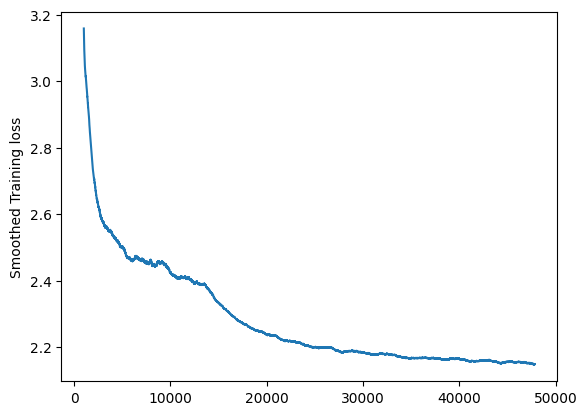

In [234]:
# Train 
model_trainer.train(n_epochs, bs, training_data_frac)

# And now finish what GRRM Started...

In [241]:
# seq = text_handler.decode(text_handler.X_test[0].tolist())
seq = "Tyrio"
model_trainer.generate_text(seq, temp=0.9, n_steps=500)

Tyrioning of sting ret that her rifars hap st he a the. Thalayet pan Ner was witgory singhers gi not had he opt her jon, a of Jandent feradom vasilitarre his clot and whough gidr the go the dam ay halint yee to grewes to thas Band ase in barme of that. “I was a to lifustilll.
Asen Freted.
“Nihtae, hib,” Sweere fout. Yoirs olit the gat of atate waith pathel to Stren dorshet gaired thene the g oo the brad Koming thirnd. “I akte yours sol,

—the brise nighes to hip thould, unked to wat rory flitede not 
